In [115]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import time
import math
import scipy.stats as stats
import itertools

In [19]:
# Load CMPP stock dataset
df_cmpp = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='CMPP.JK')
df_cmpp.set_index('Date', drop=True, inplace=True)
df_cmpp.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-04,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-05,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-06,59508224.0,59508224.0,59508224.0,59508224.0,59508224.0,20165.0
2011-04-07,55788960.0,65707001.0,52069695.0,55788960.0,55788960.0,1205883.0


In [20]:
# Check datatypes
print(df_cmpp.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [21]:
# Check missing value
print(df_cmpp.isnull().sum())

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64


In [22]:
# Fill missing value using mean imputation
for i in df_cmpp[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
    df_cmpp[i].fillna(df_cmpp[i].mean(), inplace=True)

print(df_cmpp.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


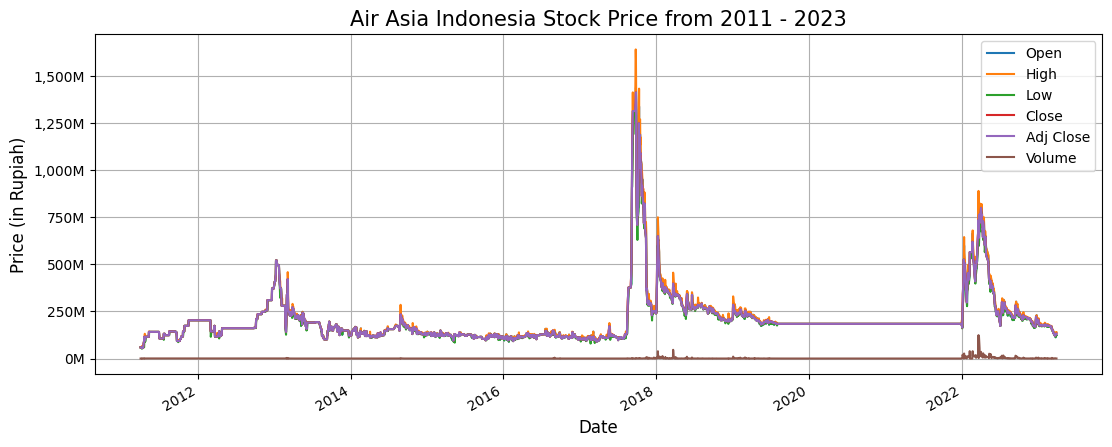

In [23]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_cmpp.plot(figsize=(13,5))
plt.title('Air Asia Indonesia Stock Price from 2011 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [24]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_cmpp[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [25]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.00273973]
 [0.00273973]
 [0.00273973]
 [0.00273973]
 [0.        ]] 

Testing Scaled:  [[0.30954058]
 [0.28596838]
 [0.26976249]
 [0.24913682]
 [0.2299844 ]]


In [26]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


## LSTM Default Model

In [27]:
# define the model
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
start_time=time.time()
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/cmpp_lstm_default.h5')

Epoch 1/10
24/24 [==============================] - 6s 62ms/step - loss: 0.0064 - val_loss: 7.2384e-04
Epoch 2/10
24/24 [==============================] - 1s 25ms/step - loss: 0.0018 - val_loss: 6.6126e-04
Epoch 3/10
24/24 [==============================] - 1s 26ms/step - loss: 0.0014 - val_loss: 5.4213e-04
Epoch 4/10
24/24 [==============================] - 1s 29ms/step - loss: 0.0012 - val_loss: 6.0391e-04
Epoch 5/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0011 - val_loss: 4.5648e-04
Epoch 6/10
24/24 [==============================] - 1s 28ms/step - loss: 9.8532e-04 - val_loss: 4.5154e-04
Epoch 7/10
24/24 [==============================] - 1s 28ms/step - loss: 9.2175e-04 - val_loss: 6.6931e-04
Epoch 8/10
24/24 [==============================] - 1s 29ms/step - loss: 8.5223e-04 - val_loss: 3.8966e-04
Epoch 9/10
24/24 [==============================] - 1s 27ms/step - loss: 8.0303e-04 - val_loss: 3.9346e-04
Epoch 10/10
24/24 [==============================] - 1s 3

In [28]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 1s 7ms/step
Mean Absolute Error (MAE): 0.0093928
Mean Absolute Percentage Error (MAPE): 0.06499
Root Mean Squared Error (RMSE): 0.01488
Mean Squared Error (MSE): 0.0002215
R-Squared (R2): 0.962448
T-Statistic 0.6813
P-Value 6.0393151224964124e-21
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 7ms/step


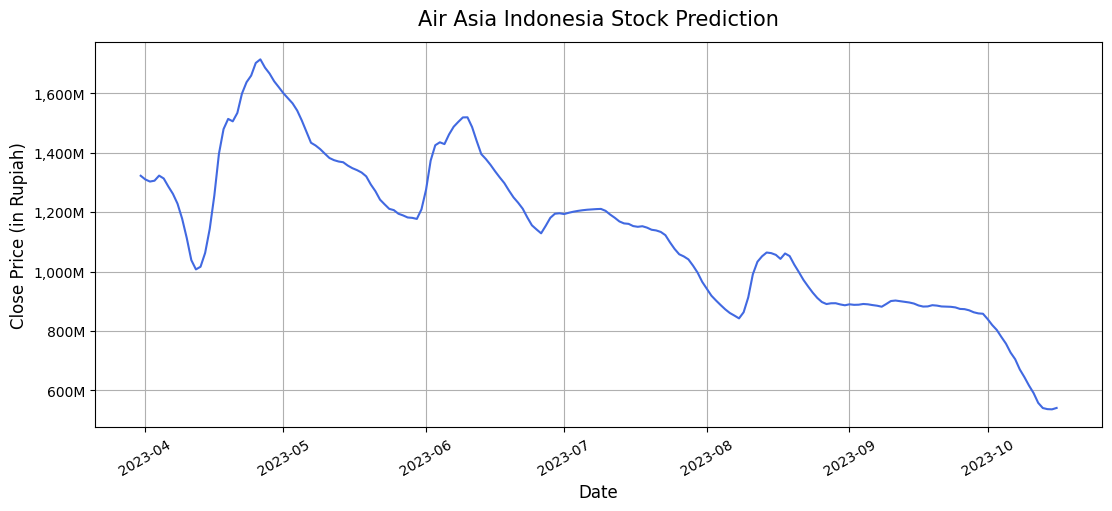

In [29]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Adam

In [30]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_linear_adam.h5')

Epoch 1/10
24/24 [==============================] - 14s 312ms/step - loss: 0.0040 - val_loss: 7.4921e-04
Epoch 2/10
24/24 [==============================] - 5s 224ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 3/10
24/24 [==============================] - 6s 231ms/step - loss: 0.0015 - val_loss: 6.3376e-04
Epoch 4/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0013 - val_loss: 4.7896e-04
Epoch 5/10
24/24 [==============================] - 6s 265ms/step - loss: 0.0012 - val_loss: 4.4536e-04
Epoch 6/10
24/24 [==============================] - 6s 238ms/step - loss: 0.0010 - val_loss: 4.6999e-04
Epoch 7/10
24/24 [==============================] - 6s 233ms/step - loss: 0.0011 - val_loss: 3.5225e-04
Epoch 8/10
24/24 [==============================] - 6s 243ms/step - loss: 8.3202e-04 - val_loss: 3.7095e-04
Epoch 9/10
24/24 [==============================] - 5s 220ms/step - loss: 9.8770e-04 - val_loss: 4.5778e-04
Epoch 10/10
24/24 [==============================] - 6s 234

In [31]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 34ms/step
Mean Absolute Error (MAE): 0.0134082
Mean Absolute Percentage Error (MAPE): 0.1056
Root Mean Squared Error (RMSE): 0.01676
Mean Squared Error (MSE): 0.0002808
R-Squared (R2): 0.952389
T-Statistic 0.7067
P-Value 3.658277667967083e-20
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 32ms/step


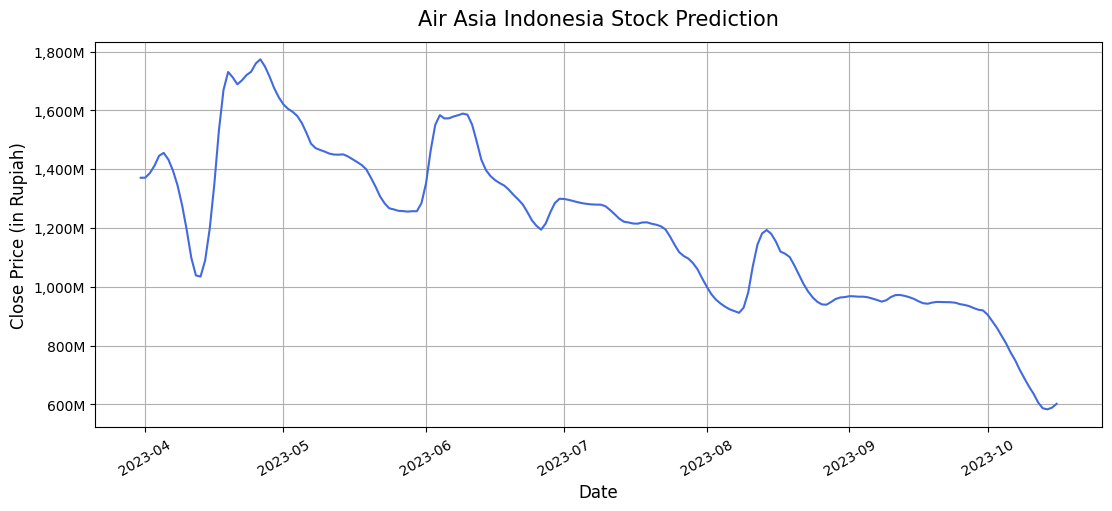

In [32]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaGrad

In [33]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_linear_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 13s 297ms/step - loss: 0.0167 - val_loss: 0.0017
Epoch 2/10
24/24 [==============================] - 6s 234ms/step - loss: 0.0124 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 5s 218ms/step - loss: 0.0120 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 5s 207ms/step - loss: 0.0116 - val_loss: 0.0011
Epoch 5/10
24/24 [==============================] - 5s 204ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 5s 206ms/step - loss: 0.0114 - val_loss: 0.0011
Epoch 7/10
24/24 [==============================] - 5s 212ms/step - loss: 0.0109 - val_loss: 0.0011
Epoch 8/10
24/24 [==============================] - 6s 246ms/step - loss: 0.0107 - val_loss: 0.0011
Epoch 9/10
24/24 [==============================] - 7s 289ms/step - loss: 0.0104 - val_loss: 0.0010
Epoch 10/10
24/24 [==============================] - 7s 282ms/step - loss: 0.0102 - val_loss: 0.001

In [34]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 3s 57ms/step
Mean Absolute Error (MAE): 0.045153
Mean Absolute Percentage Error (MAPE): 0.26926
Root Mean Squared Error (RMSE): 0.07955
Mean Squared Error (MSE): 0.0063289
R-Squared (R2): -0.073129
T-Statistic 0.7104
P-Value 4.808234172178532e-20
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 46ms/step


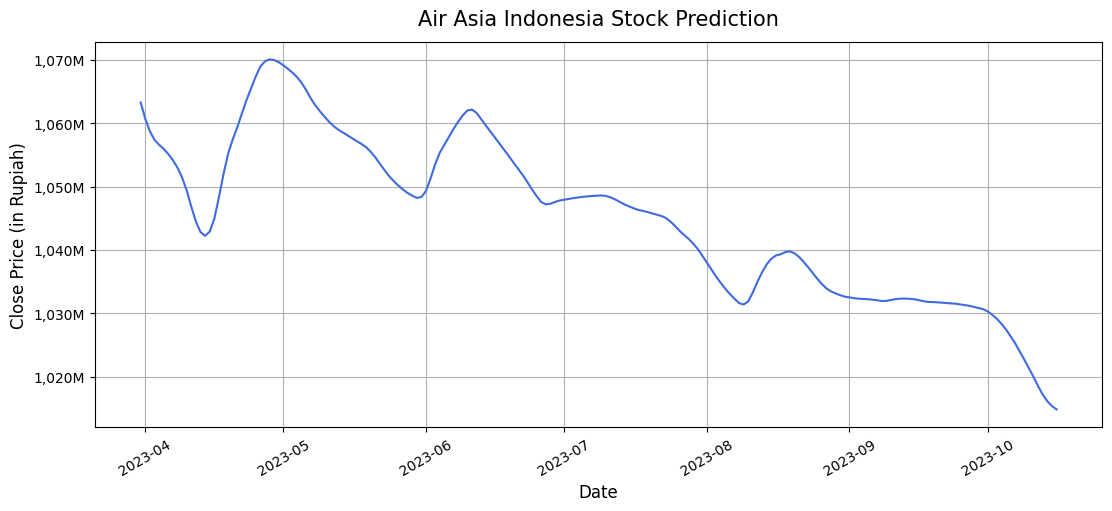

In [35]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Nadam

In [36]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_linear_nadam.h5')

Epoch 1/10
24/24 [==============================] - 16s 333ms/step - loss: 0.0047 - val_loss: 8.3098e-04
Epoch 2/10
24/24 [==============================] - 7s 308ms/step - loss: 0.0020 - val_loss: 7.0497e-04
Epoch 3/10
24/24 [==============================] - 7s 295ms/step - loss: 0.0016 - val_loss: 5.4550e-04
Epoch 4/10
24/24 [==============================] - 7s 293ms/step - loss: 0.0013 - val_loss: 6.6688e-04
Epoch 5/10
24/24 [==============================] - 9s 390ms/step - loss: 0.0011 - val_loss: 4.5274e-04
Epoch 6/10
24/24 [==============================] - 8s 313ms/step - loss: 9.9697e-04 - val_loss: 3.9391e-04
Epoch 7/10
24/24 [==============================] - 8s 330ms/step - loss: 9.3018e-04 - val_loss: 3.6864e-04
Epoch 8/10
24/24 [==============================] - 8s 328ms/step - loss: 9.2521e-04 - val_loss: 3.3684e-04
Epoch 9/10
24/24 [==============================] - 7s 306ms/step - loss: 7.8556e-04 - val_loss: 3.0250e-04
Epoch 10/10
24/24 [============================

In [37]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 33ms/step
Mean Absolute Error (MAE): 0.0093041
Mean Absolute Percentage Error (MAPE): 0.06504
Root Mean Squared Error (RMSE): 0.01434
Mean Squared Error (MSE): 0.0002055
R-Squared (R2): 0.96515
T-Statistic 0.7109
P-Value 4.961771818565445e-20
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 38ms/step


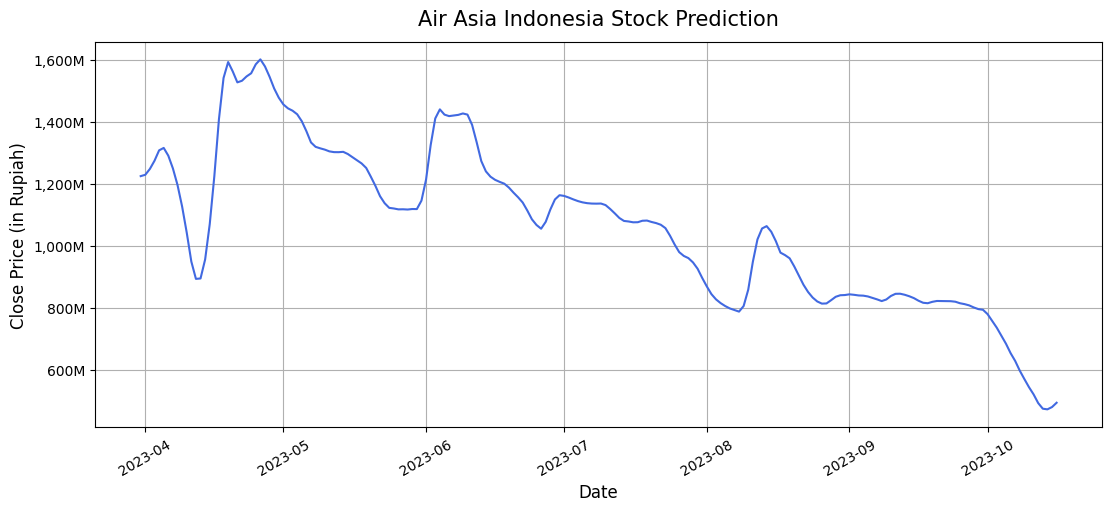

In [38]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - RMSProp

In [39]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_linear_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 15s 344ms/step - loss: 0.0041 - val_loss: 8.1855e-04
Epoch 2/10
24/24 [==============================] - 6s 250ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 3/10
24/24 [==============================] - 7s 271ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 4/10
24/24 [==============================] - 6s 245ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 5/10
24/24 [==============================] - 6s 269ms/step - loss: 0.0017 - val_loss: 5.6035e-04
Epoch 6/10
24/24 [==============================] - 6s 261ms/step - loss: 0.0018 - val_loss: 5.9321e-04
Epoch 7/10
24/24 [==============================] - 6s 268ms/step - loss: 0.0017 - val_loss: 5.5063e-04
Epoch 8/10
24/24 [==============================] - 7s 276ms/step - loss: 0.0013 - val_loss: 6.3102e-04
Epoch 9/10
24/24 [==============================] - 6s 263ms/step - loss: 0.0014 - val_loss: 5.2441e-04
Epoch 10/10
24/24 [==============================] - 7s 301ms/step - loss: 

In [40]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 44ms/step
Mean Absolute Error (MAE): 0.0203605
Mean Absolute Percentage Error (MAPE): 0.17175
Root Mean Squared Error (RMSE): 0.024
Mean Squared Error (MSE): 0.0005758
R-Squared (R2): 0.902372
T-Statistic 0.6794
P-Value 5.31158359155728e-21
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 38ms/step


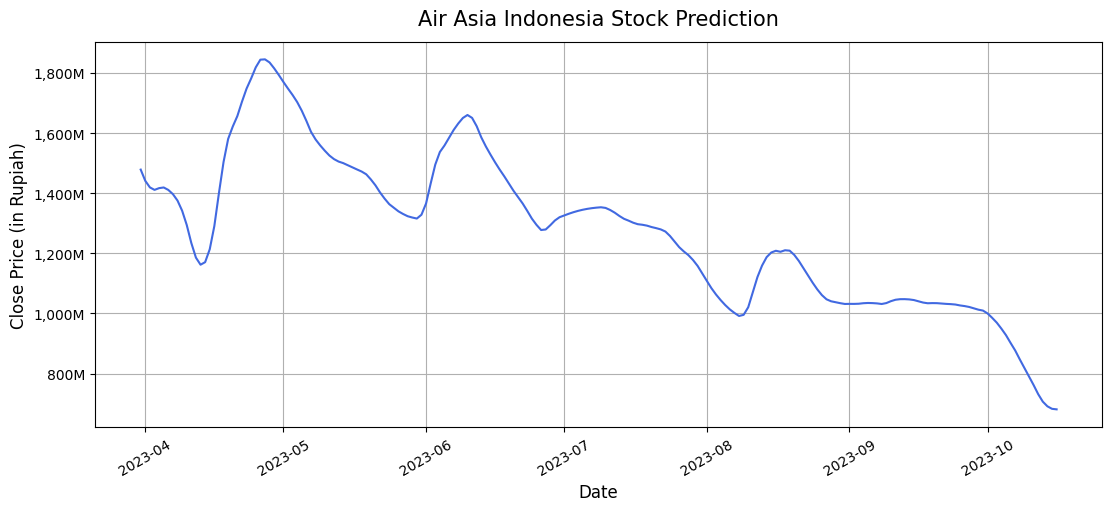

In [41]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaDelta

In [42]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_linear_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 19s 490ms/step - loss: 0.0239 - val_loss: 0.0118
Epoch 2/10
24/24 [==============================] - 10s 409ms/step - loss: 0.0236 - val_loss: 0.0115
Epoch 3/10
24/24 [==============================] - 13s 561ms/step - loss: 0.0232 - val_loss: 0.0112
Epoch 4/10
24/24 [==============================] - 13s 546ms/step - loss: 0.0229 - val_loss: 0.0110
Epoch 5/10
24/24 [==============================] - 14s 573ms/step - loss: 0.0224 - val_loss: 0.0107
Epoch 6/10
24/24 [==============================] - 14s 585ms/step - loss: 0.0222 - val_loss: 0.0104
Epoch 7/10
24/24 [==============================] - 14s 572ms/step - loss: 0.0222 - val_loss: 0.0102
Epoch 8/10
24/24 [==============================] - 13s 543ms/step - loss: 0.0216 - val_loss: 0.0099
Epoch 9/10
24/24 [==============================] - 13s 550ms/step - loss: 0.0214 - val_loss: 0.0097
Epoch 10/10
24/24 [==============================] - 15s 609ms/step - loss: 0.0210 - val_lo

In [43]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 43ms/step
Mean Absolute Error (MAE): 0.1304003
Mean Absolute Percentage Error (MAPE): 0.9311
Root Mean Squared Error (RMSE): 0.15225
Mean Squared Error (MSE): 0.0231786
R-Squared (R2): -2.930139
T-Statistic 0.6885
P-Value 9.974260148438048e-21
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 51ms/step


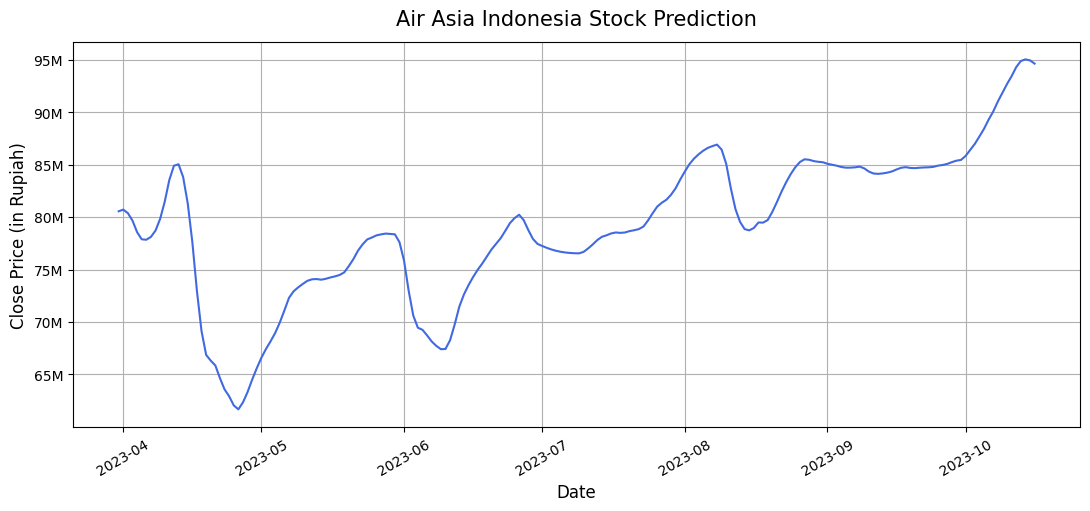

In [44]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - SGD

In [45]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_linear_sgd.h5')

Epoch 1/10
24/24 [==============================] - 21s 553ms/step - loss: 0.0120 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 12s 522ms/step - loss: 0.0099 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 14s 572ms/step - loss: 0.0094 - val_loss: 0.0010
Epoch 4/10
24/24 [==============================] - 13s 528ms/step - loss: 0.0091 - val_loss: 0.0010
Epoch 5/10
24/24 [==============================] - 16s 658ms/step - loss: 0.0085 - val_loss: 0.0010
Epoch 6/10
24/24 [==============================] - 18s 755ms/step - loss: 0.0085 - val_loss: 0.0011
Epoch 7/10
24/24 [==============================] - 16s 671ms/step - loss: 0.0078 - val_loss: 0.0010
Epoch 8/10
24/24 [==============================] - 15s 625ms/step - loss: 0.0075 - val_loss: 9.8618e-04
Epoch 9/10
24/24 [==============================] - 16s 663ms/step - loss: 0.0071 - val_loss: 9.8178e-04
Epoch 10/10
24/24 [==============================] - 18s 752ms/step - loss: 0.0069 

In [46]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 8s 82ms/step
Mean Absolute Error (MAE): 0.0307397
Mean Absolute Percentage Error (MAPE): 0.19527
Root Mean Squared Error (RMSE): 0.05415
Mean Squared Error (MSE): 0.0029318
R-Squared (R2): 0.502882
T-Statistic 0.6785
P-Value 4.9828128215004794e-21
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 1s 66ms/step


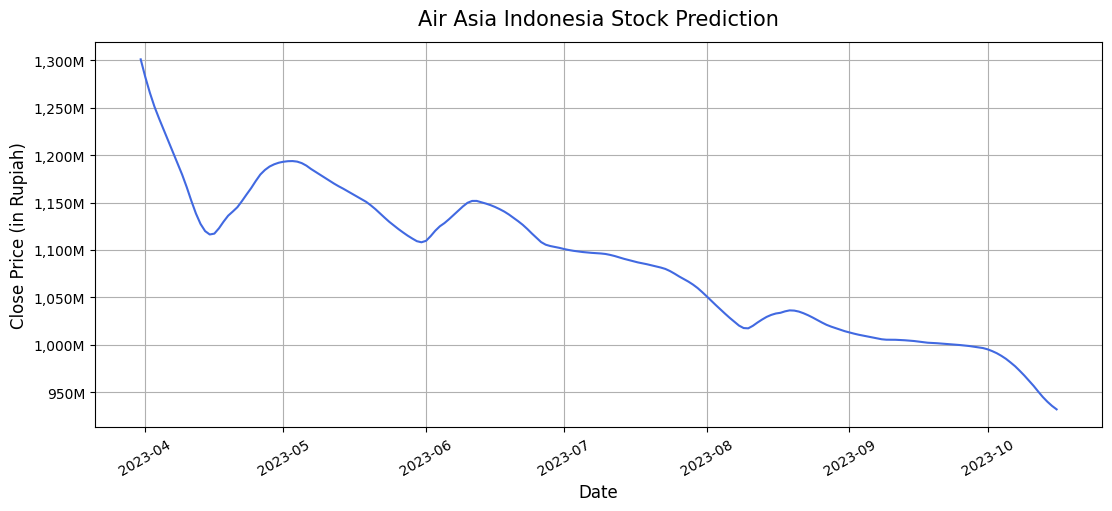

In [47]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaMax

In [48]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_linear_adamax.h5')

Epoch 1/10
24/24 [==============================] - 19s 428ms/step - loss: 0.0059 - val_loss: 8.0162e-04
Epoch 2/10
24/24 [==============================] - 9s 387ms/step - loss: 0.0023 - val_loss: 7.6044e-04
Epoch 3/10
24/24 [==============================] - 10s 420ms/step - loss: 0.0018 - val_loss: 7.2505e-04
Epoch 4/10
24/24 [==============================] - 11s 478ms/step - loss: 0.0017 - val_loss: 6.7031e-04
Epoch 5/10
24/24 [==============================] - 14s 571ms/step - loss: 0.0017 - val_loss: 6.8425e-04
Epoch 6/10
24/24 [==============================] - 11s 440ms/step - loss: 0.0015 - val_loss: 6.2806e-04
Epoch 7/10
24/24 [==============================] - 10s 417ms/step - loss: 0.0013 - val_loss: 6.0891e-04
Epoch 8/10
24/24 [==============================] - 10s 415ms/step - loss: 0.0013 - val_loss: 5.8615e-04
Epoch 9/10
24/24 [==============================] - 13s 534ms/step - loss: 0.0012 - val_loss: 5.6779e-04
Epoch 10/10
24/24 [==============================] - 12s

In [49]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 47ms/step
Mean Absolute Error (MAE): 0.0119007
Mean Absolute Percentage Error (MAPE): 0.08793
Root Mean Squared Error (RMSE): 0.01758
Mean Squared Error (MSE): 0.0003089
R-Squared (R2): 0.947628
T-Statistic 0.6855
P-Value 8.068155712748142e-21
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 42ms/step


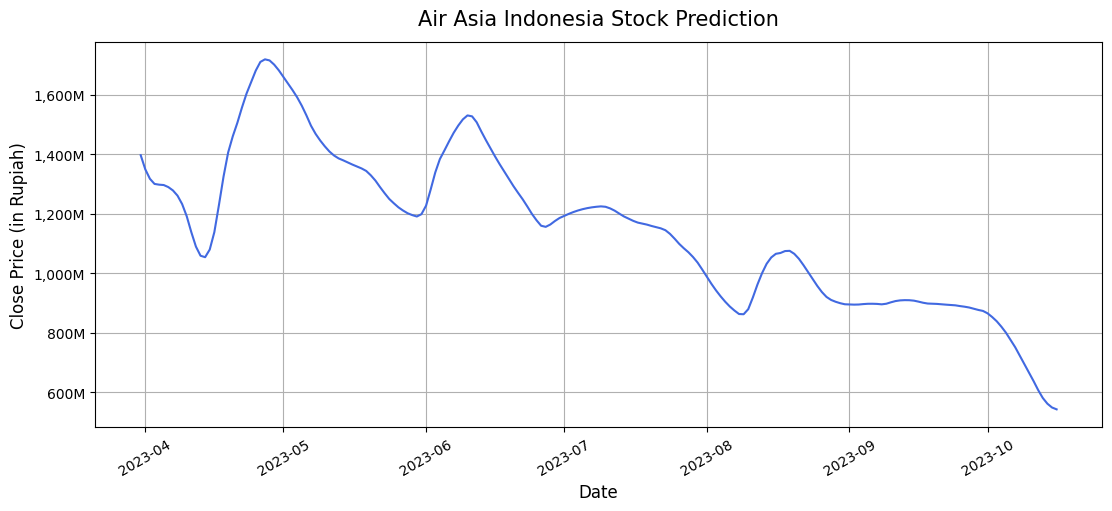

In [50]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Adam

In [51]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_relu_adam.h5')

Epoch 1/10
24/24 [==============================] - 22s 620ms/step - loss: 0.0044 - val_loss: 0.0011
Epoch 2/10
24/24 [==============================] - 13s 527ms/step - loss: 0.0018 - val_loss: 7.1880e-04
Epoch 3/10
24/24 [==============================] - 13s 534ms/step - loss: 0.0014 - val_loss: 6.1081e-04
Epoch 4/10
24/24 [==============================] - 13s 534ms/step - loss: 0.0013 - val_loss: 6.5237e-04
Epoch 5/10
24/24 [==============================] - 13s 522ms/step - loss: 0.0012 - val_loss: 5.0258e-04
Epoch 6/10
24/24 [==============================] - 12s 513ms/step - loss: 0.0012 - val_loss: 5.6100e-04
Epoch 7/10
24/24 [==============================] - 13s 531ms/step - loss: 0.0011 - val_loss: 7.5061e-04
Epoch 8/10
24/24 [==============================] - 13s 535ms/step - loss: 9.3667e-04 - val_loss: 3.7777e-04
Epoch 9/10
24/24 [==============================] - 12s 515ms/step - loss: 8.4058e-04 - val_loss: 3.7330e-04
Epoch 10/10
24/24 [==============================] 

In [52]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 44ms/step
Mean Absolute Error (MAE): 0.0089601
Mean Absolute Percentage Error (MAPE): 0.06234
Root Mean Squared Error (RMSE): 0.01402
Mean Squared Error (MSE): 0.0001965
R-Squared (R2): 0.966686
T-Statistic 0.7066
P-Value 3.6371176770396376e-20
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 44ms/step


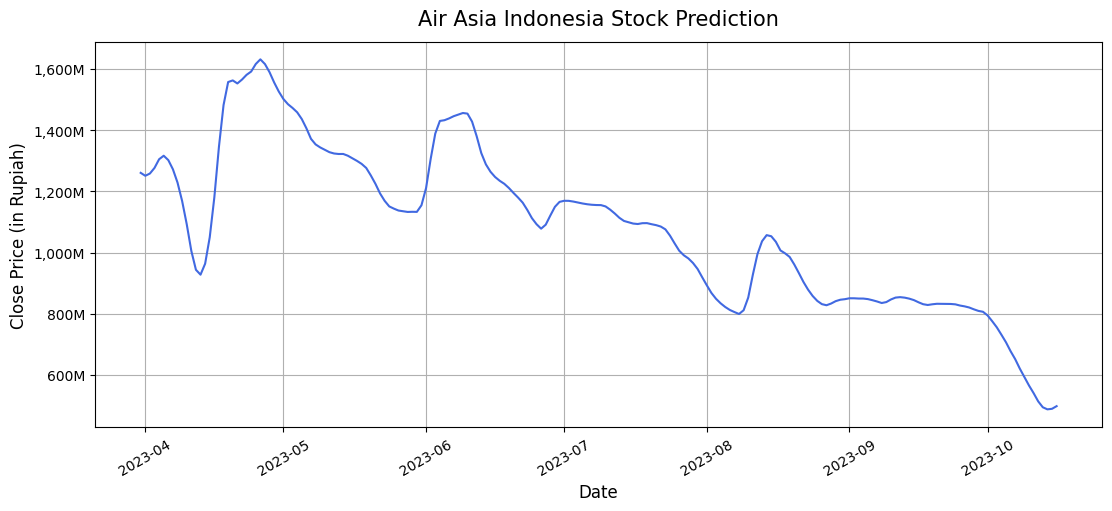

In [53]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaGrad

In [54]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_relu_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 14s 346ms/step - loss: 0.0214 - val_loss: 0.0071
Epoch 2/10
24/24 [==============================] - 6s 268ms/step - loss: 0.0177 - val_loss: 0.0053
Epoch 3/10
24/24 [==============================] - 7s 284ms/step - loss: 0.0157 - val_loss: 0.0041
Epoch 4/10
24/24 [==============================] - 7s 284ms/step - loss: 0.0143 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 7s 273ms/step - loss: 0.0134 - val_loss: 0.0026
Epoch 6/10
24/24 [==============================] - 6s 267ms/step - loss: 0.0127 - val_loss: 0.0022
Epoch 7/10
24/24 [==============================] - 6s 270ms/step - loss: 0.0121 - val_loss: 0.0018
Epoch 8/10
24/24 [==============================] - 7s 282ms/step - loss: 0.0117 - val_loss: 0.0016
Epoch 9/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0114 - val_loss: 0.0014
Epoch 10/10
24/24 [==============================] - 7s 274ms/step - loss: 0.0111 - val_loss: 0.001

In [55]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 39ms/step
Mean Absolute Error (MAE): 0.055181
Mean Absolute Percentage Error (MAPE): 0.31463
Root Mean Squared Error (RMSE): 0.08964
Mean Squared Error (MSE): 0.0080345
R-Squared (R2): -0.362323
T-Statistic 0.6989
P-Value 2.0763643782648883e-20
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 39ms/step


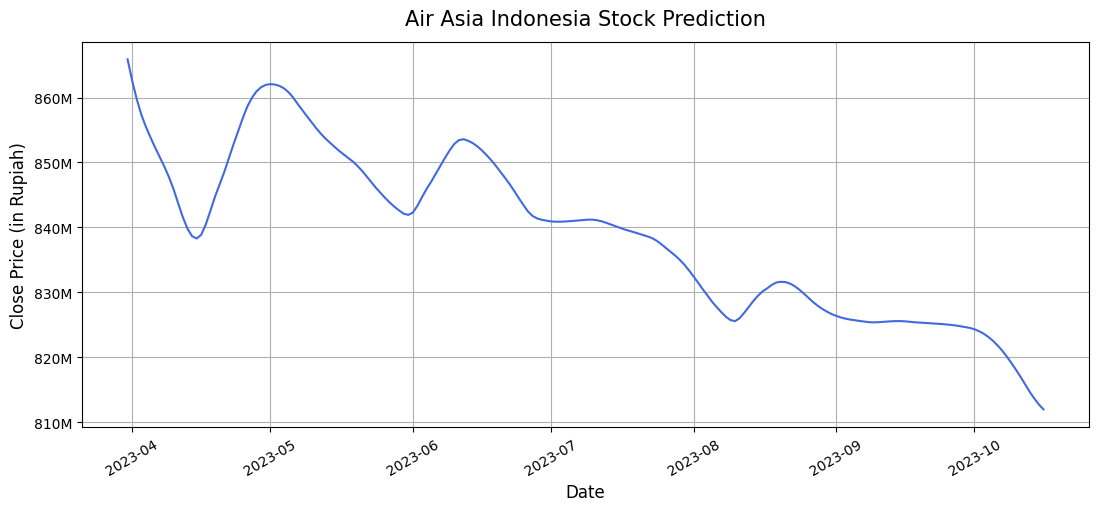

In [56]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Nadam

In [57]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_relu_nadam.h5')

Epoch 1/10
24/24 [==============================] - 18s 413ms/step - loss: 0.0042 - val_loss: 8.0483e-04
Epoch 2/10
24/24 [==============================] - 7s 311ms/step - loss: 0.0020 - val_loss: 6.4458e-04
Epoch 3/10
24/24 [==============================] - 7s 311ms/step - loss: 0.0015 - val_loss: 5.8121e-04
Epoch 4/10
24/24 [==============================] - 7s 310ms/step - loss: 0.0013 - val_loss: 5.2021e-04
Epoch 5/10
24/24 [==============================] - 8s 321ms/step - loss: 0.0012 - val_loss: 4.8132e-04
Epoch 6/10
24/24 [==============================] - 8s 319ms/step - loss: 0.0012 - val_loss: 5.1350e-04
Epoch 7/10
24/24 [==============================] - 7s 310ms/step - loss: 9.4702e-04 - val_loss: 3.8735e-04
Epoch 8/10
24/24 [==============================] - 8s 332ms/step - loss: 9.9060e-04 - val_loss: 3.9210e-04
Epoch 9/10
24/24 [==============================] - 8s 331ms/step - loss: 0.0010 - val_loss: 3.4488e-04
Epoch 10/10
24/24 [==============================] - 9s

In [58]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 40ms/step
Mean Absolute Error (MAE): 0.0083149
Mean Absolute Percentage Error (MAPE): 0.05751
Root Mean Squared Error (RMSE): 0.01366
Mean Squared Error (MSE): 0.0001867
R-Squared (R2): 0.96834
T-Statistic 0.71
P-Value 4.6352031745514974e-20
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 42ms/step


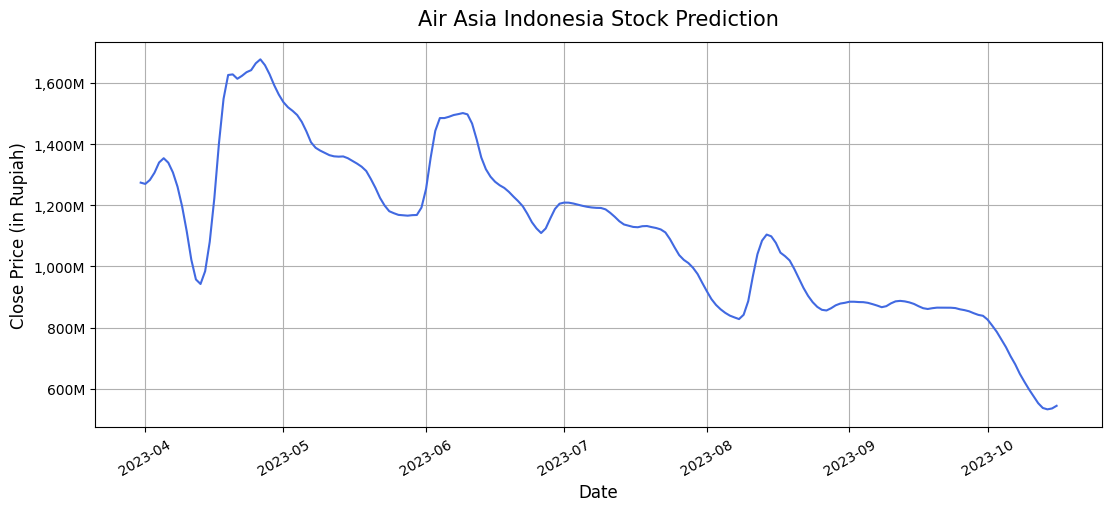

In [59]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - RMSProp

In [60]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_relu_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 19s 560ms/step - loss: 0.0062 - val_loss: 0.0012
Epoch 2/10
24/24 [==============================] - 12s 508ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 15s 640ms/step - loss: 0.0023 - val_loss: 9.7917e-04
Epoch 4/10
24/24 [==============================] - 16s 659ms/step - loss: 0.0022 - val_loss: 7.5040e-04
Epoch 5/10
24/24 [==============================] - 17s 706ms/step - loss: 0.0020 - val_loss: 8.4931e-04
Epoch 6/10
24/24 [==============================] - 13s 531ms/step - loss: 0.0016 - val_loss: 6.6970e-04
Epoch 7/10
24/24 [==============================] - 12s 505ms/step - loss: 0.0016 - val_loss: 7.1782e-04
Epoch 8/10
24/24 [==============================] - 12s 504ms/step - loss: 0.0016 - val_loss: 5.5391e-04
Epoch 9/10
24/24 [==============================] - 13s 541ms/step - loss: 0.0015 - val_loss: 5.4063e-04
Epoch 10/10
24/24 [==============================] - 13s 550ms/

In [61]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 3s 73ms/step
Mean Absolute Error (MAE): 0.0156505
Mean Absolute Percentage Error (MAPE): 0.10101
Root Mean Squared Error (RMSE): 0.02545
Mean Squared Error (MSE): 0.0006476
R-Squared (R2): 0.890188
T-Statistic 0.6813
P-Value 6.047188282496655e-21
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 60ms/step


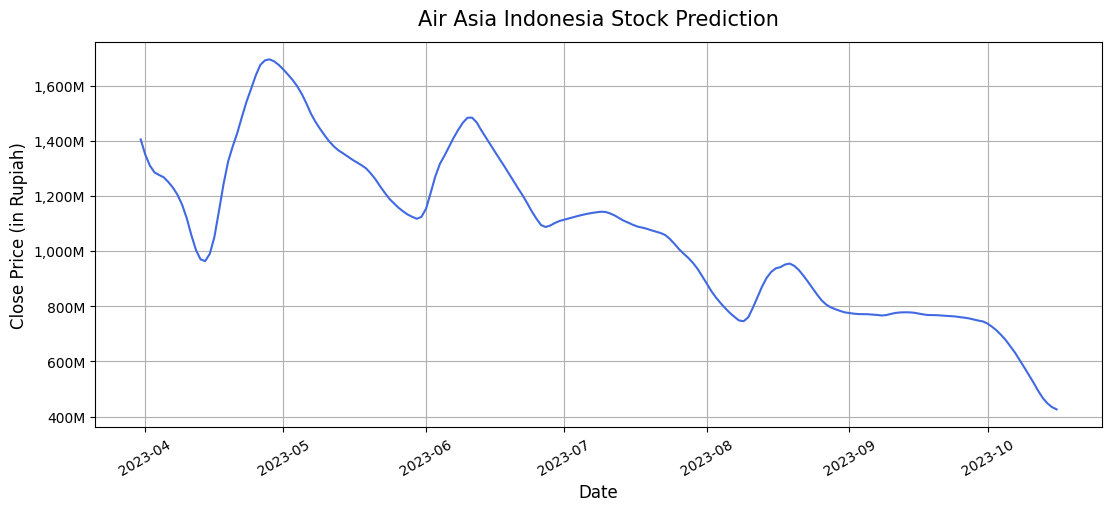

In [62]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaDelta

In [63]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_relu_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 23s 585ms/step - loss: 0.0224 - val_loss: 0.0111
Epoch 2/10
24/24 [==============================] - 11s 473ms/step - loss: 0.0225 - val_loss: 0.0109
Epoch 3/10
24/24 [==============================] - 12s 518ms/step - loss: 0.0221 - val_loss: 0.0108
Epoch 4/10
24/24 [==============================] - 11s 468ms/step - loss: 0.0221 - val_loss: 0.0106
Epoch 5/10
24/24 [==============================] - 12s 493ms/step - loss: 0.0219 - val_loss: 0.0104
Epoch 6/10
24/24 [==============================] - 12s 519ms/step - loss: 0.0218 - val_loss: 0.0103
Epoch 7/10
24/24 [==============================] - 13s 533ms/step - loss: 0.0216 - val_loss: 0.0101
Epoch 8/10
24/24 [==============================] - 13s 530ms/step - loss: 0.0213 - val_loss: 0.0100
Epoch 9/10
24/24 [==============================] - 13s 522ms/step - loss: 0.0210 - val_loss: 0.0098
Epoch 10/10
24/24 [==============================] - 13s 546ms/step - loss: 0.0209 - val_lo

In [64]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 71ms/step
Mean Absolute Error (MAE): 0.1303228
Mean Absolute Percentage Error (MAPE): 0.93673
Root Mean Squared Error (RMSE): 0.15098
Mean Squared Error (MSE): 0.0227959
R-Squared (R2): -2.865256
T-Statistic 0.6974
P-Value 1.8693982960078655e-20
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 68ms/step


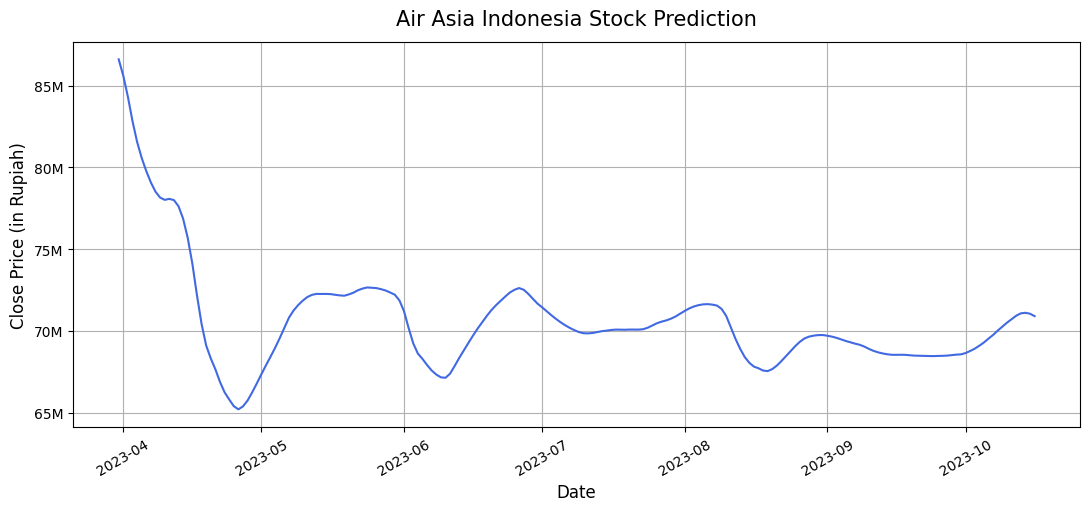

In [65]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - SGD

In [66]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_relu_sgd.h5')

Epoch 1/10
24/24 [==============================] - 24s 621ms/step - loss: 0.0137 - val_loss: 0.0011
Epoch 2/10
24/24 [==============================] - 13s 529ms/step - loss: 0.0105 - val_loss: 0.0010
Epoch 3/10
24/24 [==============================] - 12s 519ms/step - loss: 0.0099 - val_loss: 0.0010
Epoch 4/10
24/24 [==============================] - 12s 496ms/step - loss: 0.0094 - val_loss: 0.0010
Epoch 5/10
24/24 [==============================] - 13s 533ms/step - loss: 0.0091 - val_loss: 9.9757e-04
Epoch 6/10
24/24 [==============================] - 12s 516ms/step - loss: 0.0087 - val_loss: 9.9189e-04
Epoch 7/10
24/24 [==============================] - 13s 556ms/step - loss: 0.0083 - val_loss: 9.8384e-04
Epoch 8/10
24/24 [==============================] - 13s 533ms/step - loss: 0.0081 - val_loss: 9.8102e-04
Epoch 9/10
24/24 [==============================] - 13s 526ms/step - loss: 0.0078 - val_loss: 9.7792e-04
Epoch 10/10
24/24 [==============================] - 13s 538ms/step - l

In [67]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 51ms/step
Mean Absolute Error (MAE): 0.0338009
Mean Absolute Percentage Error (MAPE): 0.20772
Root Mean Squared Error (RMSE): 0.05929
Mean Squared Error (MSE): 0.003515
R-Squared (R2): 0.403997
T-Statistic 0.6778
P-Value 4.77333458202961e-21
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 52ms/step


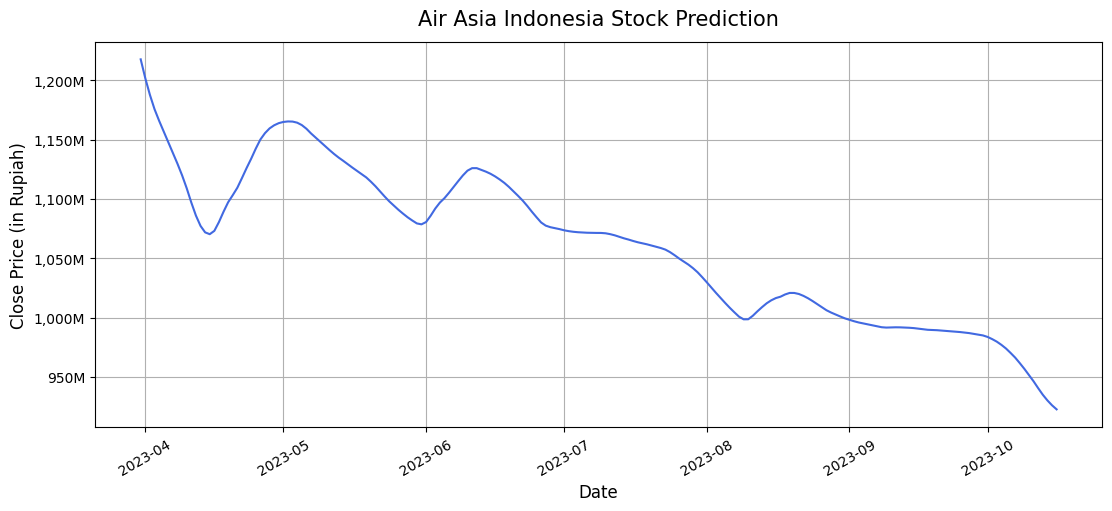

In [68]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaMax

In [69]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_relu_adamax.h5')

Epoch 1/10
24/24 [==============================] - 20s 527ms/step - loss: 0.0046 - val_loss: 8.0119e-04
Epoch 2/10
24/24 [==============================] - 12s 510ms/step - loss: 0.0021 - val_loss: 7.4888e-04
Epoch 3/10
24/24 [==============================] - 13s 529ms/step - loss: 0.0018 - val_loss: 7.2134e-04
Epoch 4/10
24/24 [==============================] - 13s 529ms/step - loss: 0.0017 - val_loss: 6.8033e-04
Epoch 5/10
24/24 [==============================] - 12s 511ms/step - loss: 0.0015 - val_loss: 6.3427e-04
Epoch 6/10
24/24 [==============================] - 12s 521ms/step - loss: 0.0015 - val_loss: 6.2063e-04
Epoch 7/10
24/24 [==============================] - 12s 521ms/step - loss: 0.0014 - val_loss: 6.0112e-04
Epoch 8/10
24/24 [==============================] - 12s 489ms/step - loss: 0.0013 - val_loss: 5.8518e-04
Epoch 9/10
24/24 [==============================] - 12s 483ms/step - loss: 0.0014 - val_loss: 5.8222e-04
Epoch 10/10
24/24 [==============================] - 12

In [70]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 45ms/step
Mean Absolute Error (MAE): 0.0106818
Mean Absolute Percentage Error (MAPE): 0.07497
Root Mean Squared Error (RMSE): 0.01704
Mean Squared Error (MSE): 0.0002903
R-Squared (R2): 0.95077
T-Statistic 0.6834
P-Value 7.00239569357822e-21
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 46ms/step


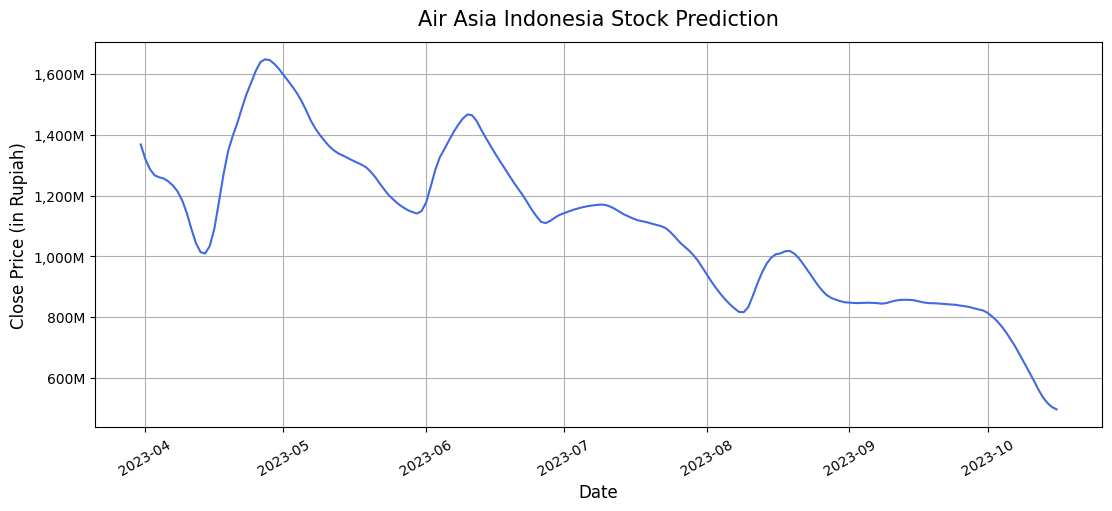

In [71]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Adam

In [72]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_sigmoid_adam.h5')

Epoch 1/10
24/24 [==============================] - 18s 470ms/step - loss: 0.0075 - val_loss: 9.6619e-04
Epoch 2/10
24/24 [==============================] - 9s 386ms/step - loss: 0.0022 - val_loss: 7.9908e-04
Epoch 3/10
24/24 [==============================] - 9s 368ms/step - loss: 0.0016 - val_loss: 6.7372e-04
Epoch 4/10
24/24 [==============================] - 8s 349ms/step - loss: 0.0016 - val_loss: 6.3875e-04
Epoch 5/10
24/24 [==============================] - 8s 354ms/step - loss: 0.0013 - val_loss: 5.8850e-04
Epoch 6/10
24/24 [==============================] - 9s 360ms/step - loss: 0.0011 - val_loss: 5.4568e-04
Epoch 7/10
24/24 [==============================] - 9s 364ms/step - loss: 0.0011 - val_loss: 5.0339e-04
Epoch 8/10
24/24 [==============================] - 9s 356ms/step - loss: 0.0010 - val_loss: 4.5627e-04
Epoch 9/10
24/24 [==============================] - 9s 380ms/step - loss: 0.0010 - val_loss: 4.3800e-04
Epoch 10/10
24/24 [==============================] - 9s 373ms/s

In [73]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 43ms/step
Mean Absolute Error (MAE): 0.0107519
Mean Absolute Percentage Error (MAPE): 0.07679
Root Mean Squared Error (RMSE): 0.01595
Mean Squared Error (MSE): 0.0002543
R-Squared (R2): 0.956888
T-Statistic 0.6949
P-Value 1.557205792546148e-20
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 46ms/step


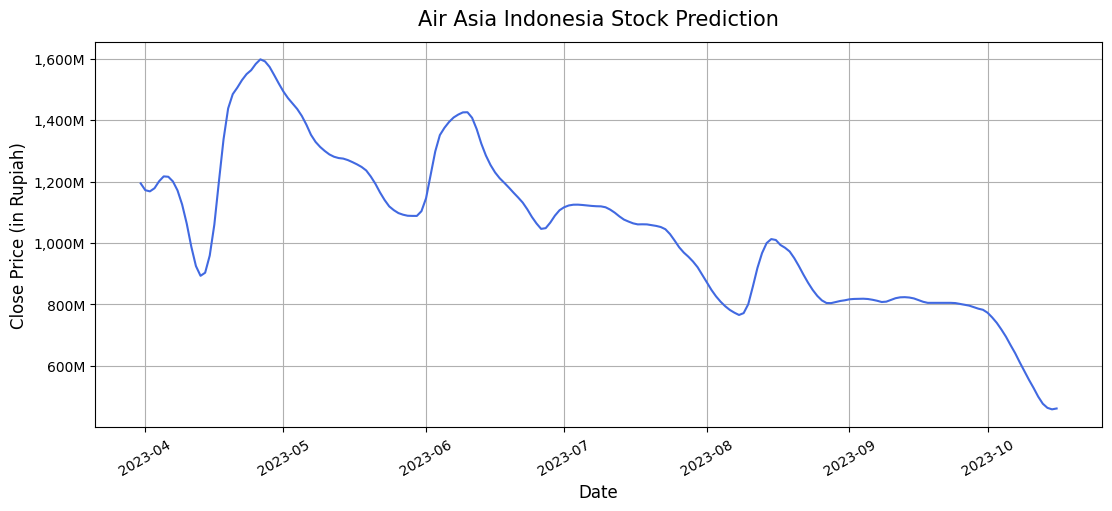

In [74]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaGrad

In [75]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_sigmoid_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 15s 367ms/step - loss: 0.0864 - val_loss: 0.0455
Epoch 2/10
24/24 [==============================] - 6s 267ms/step - loss: 0.0453 - val_loss: 0.0235
Epoch 3/10
24/24 [==============================] - 7s 279ms/step - loss: 0.0292 - val_loss: 0.0132
Epoch 4/10
24/24 [==============================] - 7s 283ms/step - loss: 0.0211 - val_loss: 0.0077
Epoch 5/10
24/24 [==============================] - 7s 289ms/step - loss: 0.0167 - val_loss: 0.0047
Epoch 6/10
24/24 [==============================] - 7s 304ms/step - loss: 0.0143 - val_loss: 0.0031
Epoch 7/10
24/24 [==============================] - 7s 302ms/step - loss: 0.0128 - val_loss: 0.0022
Epoch 8/10
24/24 [==============================] - 7s 282ms/step - loss: 0.0121 - val_loss: 0.0016
Epoch 9/10
24/24 [==============================] - 7s 291ms/step - loss: 0.0116 - val_loss: 0.0014
Epoch 10/10
24/24 [==============================] - 7s 300ms/step - loss: 0.0113 - val_loss: 0.001

In [76]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 42ms/step
Mean Absolute Error (MAE): 0.0541564
Mean Absolute Percentage Error (MAPE): 0.30342
Root Mean Squared Error (RMSE): 0.09116
Mean Squared Error (MSE): 0.0083093
R-Squared (R2): -0.408912
T-Statistic 0.64
P-Value 4.053440718660872e-22
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 42ms/step


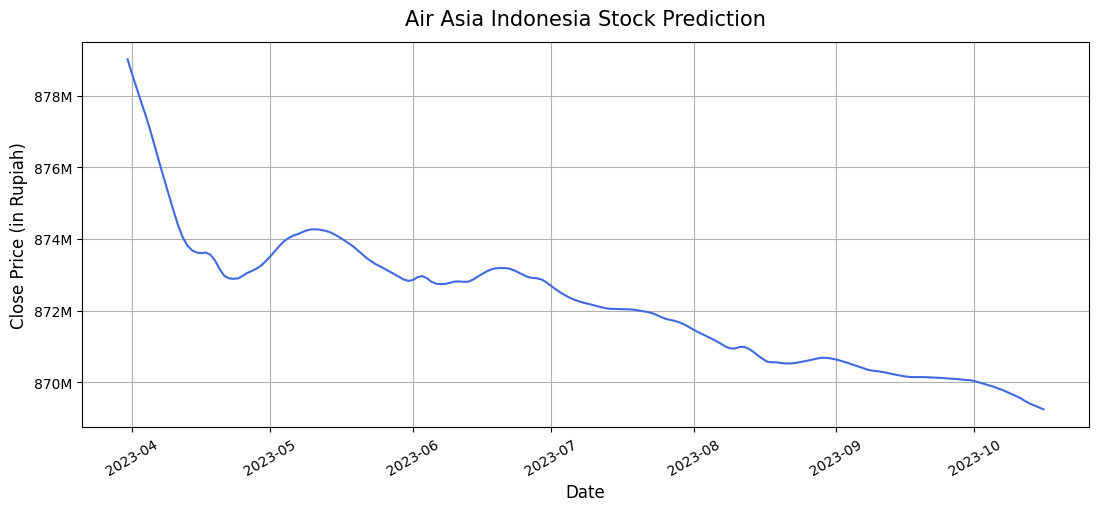

In [77]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Nadam

In [78]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_sigmoid_nadam.h5')

Epoch 1/10
24/24 [==============================] - 17s 365ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 2/10
24/24 [==============================] - 7s 298ms/step - loss: 0.0019 - val_loss: 8.7717e-04
Epoch 3/10
24/24 [==============================] - 8s 315ms/step - loss: 0.0017 - val_loss: 6.6200e-04
Epoch 4/10
24/24 [==============================] - 8s 327ms/step - loss: 0.0014 - val_loss: 6.2870e-04
Epoch 5/10
24/24 [==============================] - 8s 337ms/step - loss: 0.0012 - val_loss: 5.6976e-04
Epoch 6/10
24/24 [==============================] - 8s 324ms/step - loss: 0.0011 - val_loss: 5.3483e-04
Epoch 7/10
24/24 [==============================] - 8s 329ms/step - loss: 0.0011 - val_loss: 5.2427e-04
Epoch 8/10
24/24 [==============================] - 8s 313ms/step - loss: 0.0011 - val_loss: 4.1635e-04
Epoch 9/10
24/24 [==============================] - 7s 309ms/step - loss: 9.4599e-04 - val_loss: 4.5107e-04
Epoch 10/10
24/24 [==============================] - 7s 310ms/s

In [79]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 44ms/step
Mean Absolute Error (MAE): 0.0131355
Mean Absolute Percentage Error (MAPE): 0.10864
Root Mean Squared Error (RMSE): 0.01594
Mean Squared Error (MSE): 0.0002541
R-Squared (R2): 0.956923
T-Statistic 0.7041
P-Value 3.017230787814386e-20
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 45ms/step


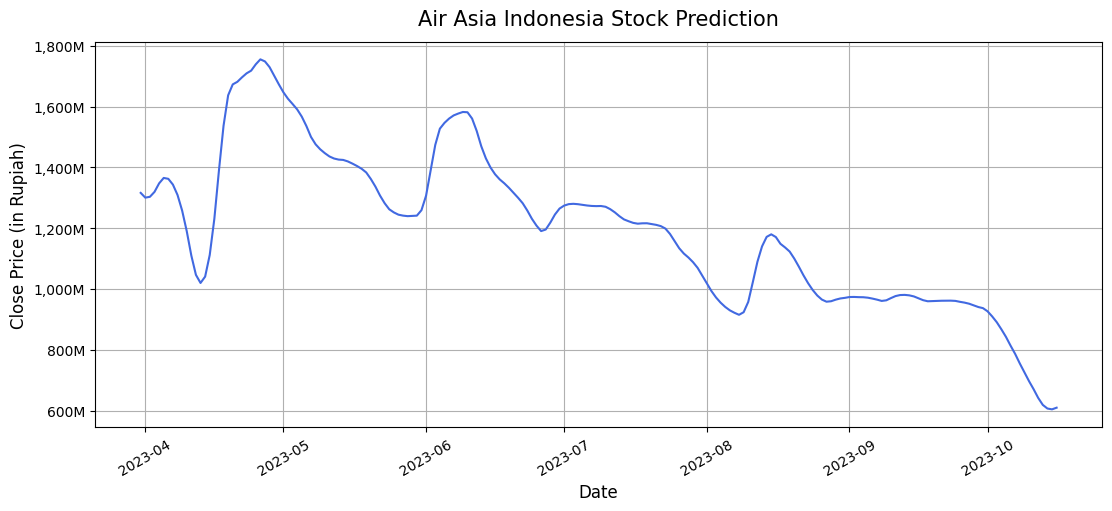

In [80]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - RMSProp

In [81]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_sigmoid_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 17s 431ms/step - loss: 0.0526 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 8s 327ms/step - loss: 0.0129 - val_loss: 0.0014
Epoch 3/10
24/24 [==============================] - 8s 339ms/step - loss: 0.0083 - val_loss: 0.0077
Epoch 4/10
24/24 [==============================] - 8s 352ms/step - loss: 0.0078 - val_loss: 0.0022
Epoch 5/10
24/24 [==============================] - 8s 346ms/step - loss: 0.0060 - val_loss: 0.0030
Epoch 6/10
24/24 [==============================] - 8s 347ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 7/10
24/24 [==============================] - 8s 353ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 8/10
24/24 [==============================] - 9s 364ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 9/10
24/24 [==============================] - 9s 363ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/10
24/24 [==============================] - 9s 358ms/step - loss: 0.0032 - val_loss: 0.001

In [82]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 47ms/step
Mean Absolute Error (MAE): 0.0333269
Mean Absolute Percentage Error (MAPE): 0.26258
Root Mean Squared Error (RMSE): 0.04121
Mean Squared Error (MSE): 0.0016979
R-Squared (R2): 0.712099
T-Statistic 0.6341
P-Value 2.805322917339954e-22
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 47ms/step


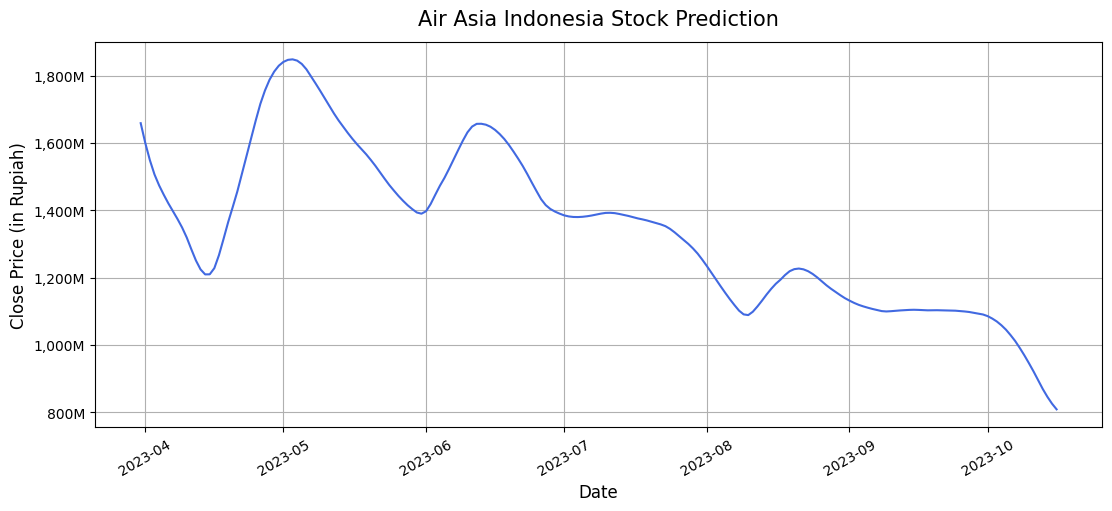

In [83]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaDelta

In [84]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_sigmoid_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 17s 378ms/step - loss: 0.1574 - val_loss: 0.1506
Epoch 2/10
24/24 [==============================] - 8s 349ms/step - loss: 0.1567 - val_loss: 0.1498
Epoch 3/10
24/24 [==============================] - 8s 330ms/step - loss: 0.1559 - val_loss: 0.1491
Epoch 4/10
24/24 [==============================] - 8s 335ms/step - loss: 0.1552 - val_loss: 0.1483
Epoch 5/10
24/24 [==============================] - 9s 359ms/step - loss: 0.1544 - val_loss: 0.1475
Epoch 6/10
24/24 [==============================] - 8s 329ms/step - loss: 0.1537 - val_loss: 0.1467
Epoch 7/10
24/24 [==============================] - 8s 326ms/step - loss: 0.1529 - val_loss: 0.1459
Epoch 8/10
24/24 [==============================] - 8s 350ms/step - loss: 0.1521 - val_loss: 0.1451
Epoch 9/10
24/24 [==============================] - 9s 386ms/step - loss: 0.1512 - val_loss: 0.1443
Epoch 10/10
24/24 [==============================] - 10s 417ms/step - loss: 0.1505 - val_loss: 0.14

In [85]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 3s 50ms/step
Mean Absolute Error (MAE): 0.3396395
Mean Absolute Percentage Error (MAPE): 3.17535
Root Mean Squared Error (RMSE): 0.34795
Mean Squared Error (MSE): 0.1210713
R-Squared (R2): -19.528718
T-Statistic 0.6558
P-Value 1.1052384053995258e-21
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 47ms/step


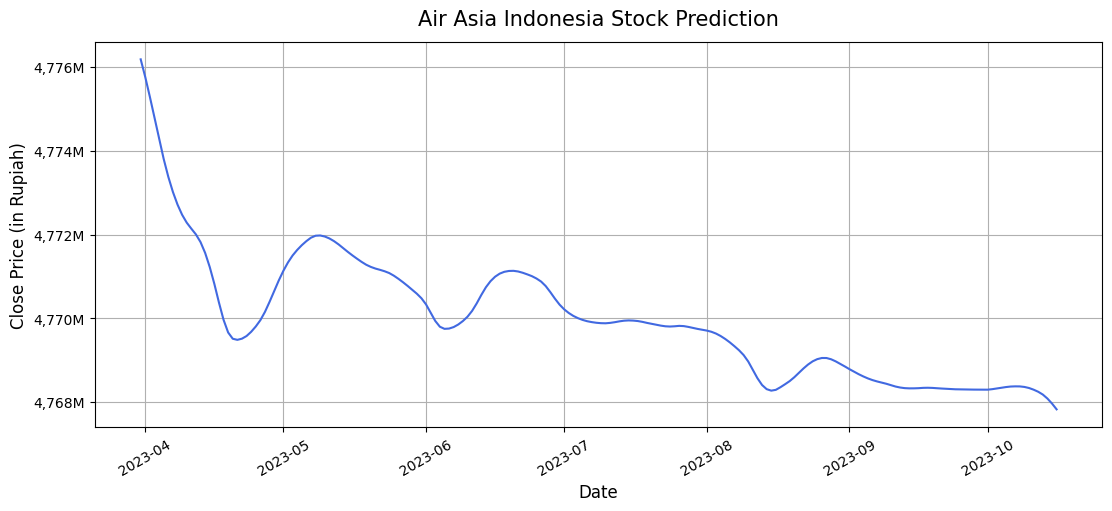

In [86]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - SGD

In [87]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_sigmoid_sgd.h5')

Epoch 1/10
24/24 [==============================] - 20s 495ms/step - loss: 0.0398 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 9s 378ms/step - loss: 0.0105 - val_loss: 0.0011
Epoch 3/10
24/24 [==============================] - 9s 367ms/step - loss: 0.0105 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 9s 370ms/step - loss: 0.0104 - val_loss: 0.0011
Epoch 5/10
24/24 [==============================] - 9s 370ms/step - loss: 0.0105 - val_loss: 0.0010
Epoch 6/10
24/24 [==============================] - 9s 376ms/step - loss: 0.0104 - val_loss: 0.0010
Epoch 7/10
24/24 [==============================] - 9s 366ms/step - loss: 0.0104 - val_loss: 0.0013
Epoch 8/10
24/24 [==============================] - 9s 381ms/step - loss: 0.0104 - val_loss: 0.0010
Epoch 9/10
24/24 [==============================] - 9s 374ms/step - loss: 0.0103 - val_loss: 0.0011
Epoch 10/10
24/24 [==============================] - 9s 359ms/step - loss: 0.0103 - val_loss: 0.001

In [88]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 48ms/step
Mean Absolute Error (MAE): 0.046464
Mean Absolute Percentage Error (MAPE): 0.27272
Root Mean Squared Error (RMSE): 0.08124
Mean Squared Error (MSE): 0.0065997
R-Squared (R2): -0.11903
T-Statistic 0.671
P-Value 3.0044066206526515e-21
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 47ms/step


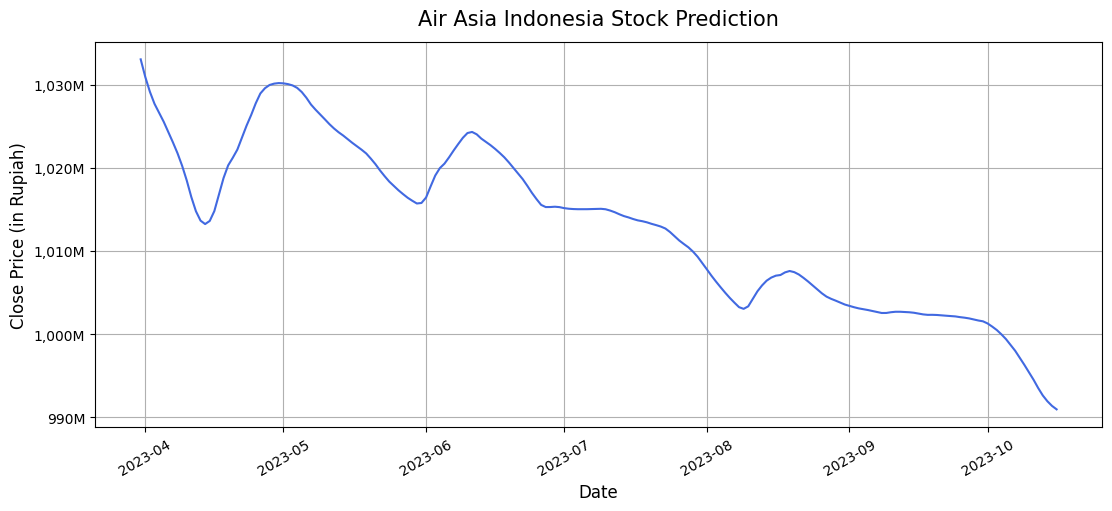

In [89]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaMax

In [90]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_sigmoid_adamax.h5')

Epoch 1/10
24/24 [==============================] - 17s 414ms/step - loss: 0.3013 - val_loss: 0.0114
Epoch 2/10
24/24 [==============================] - 8s 328ms/step - loss: 0.0281 - val_loss: 0.0018
Epoch 3/10
24/24 [==============================] - 8s 330ms/step - loss: 0.0176 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 8s 339ms/step - loss: 0.0166 - val_loss: 0.0011
Epoch 5/10
24/24 [==============================] - 9s 355ms/step - loss: 0.0153 - val_loss: 0.0011
Epoch 6/10
24/24 [==============================] - 8s 338ms/step - loss: 0.0143 - val_loss: 0.0011
Epoch 7/10
24/24 [==============================] - 8s 338ms/step - loss: 0.0123 - val_loss: 0.0011
Epoch 8/10
24/24 [==============================] - 8s 351ms/step - loss: 0.0116 - val_loss: 0.0010
Epoch 9/10
24/24 [==============================] - 9s 396ms/step - loss: 0.0101 - val_loss: 0.0021
Epoch 10/10
24/24 [==============================] - 9s 356ms/step - loss: 0.0092 - val_loss: 0.001

In [91]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 51ms/step
Mean Absolute Error (MAE): 0.0343761
Mean Absolute Percentage Error (MAPE): 0.24015
Root Mean Squared Error (RMSE): 0.05322
Mean Squared Error (MSE): 0.0028328
R-Squared (R2): 0.519669
T-Statistic 0.7381
P-Value 4.007550739584992e-19
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 48ms/step


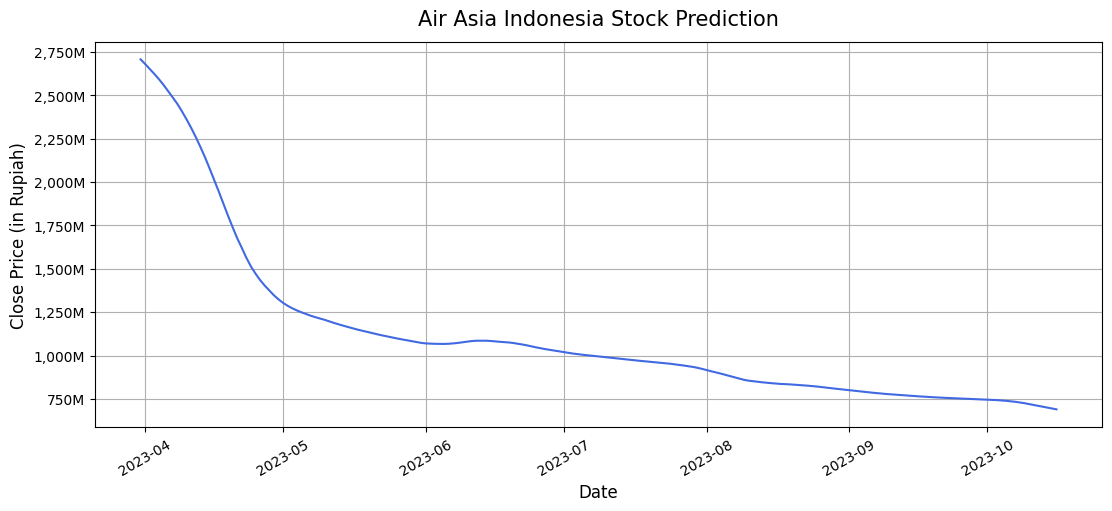

In [92]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Adam

In [93]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_tanh_adam.h5')

Epoch 1/10
24/24 [==============================] - 20s 487ms/step - loss: 0.0036 - val_loss: 7.2345e-04
Epoch 2/10
24/24 [==============================] - 8s 342ms/step - loss: 0.0017 - val_loss: 9.6907e-04
Epoch 3/10
24/24 [==============================] - 8s 317ms/step - loss: 0.0014 - val_loss: 5.0612e-04
Epoch 4/10
24/24 [==============================] - 8s 343ms/step - loss: 0.0012 - val_loss: 4.6405e-04
Epoch 5/10
24/24 [==============================] - 8s 327ms/step - loss: 0.0012 - val_loss: 4.5736e-04
Epoch 6/10
24/24 [==============================] - 8s 334ms/step - loss: 0.0010 - val_loss: 4.1118e-04
Epoch 7/10
24/24 [==============================] - 8s 324ms/step - loss: 8.4701e-04 - val_loss: 3.3680e-04
Epoch 8/10
24/24 [==============================] - 8s 331ms/step - loss: 9.1388e-04 - val_loss: 3.1521e-04
Epoch 9/10
24/24 [==============================] - 8s 347ms/step - loss: 7.8610e-04 - val_loss: 4.1421e-04
Epoch 10/10
24/24 [==============================] 

In [94]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 49ms/step
Mean Absolute Error (MAE): 0.0109219
Mean Absolute Percentage Error (MAPE): 0.08917
Root Mean Squared Error (RMSE): 0.01474
Mean Squared Error (MSE): 0.0002174
R-Squared (R2): 0.963132
T-Statistic 0.7086
P-Value 4.1970633755406314e-20
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 47ms/step


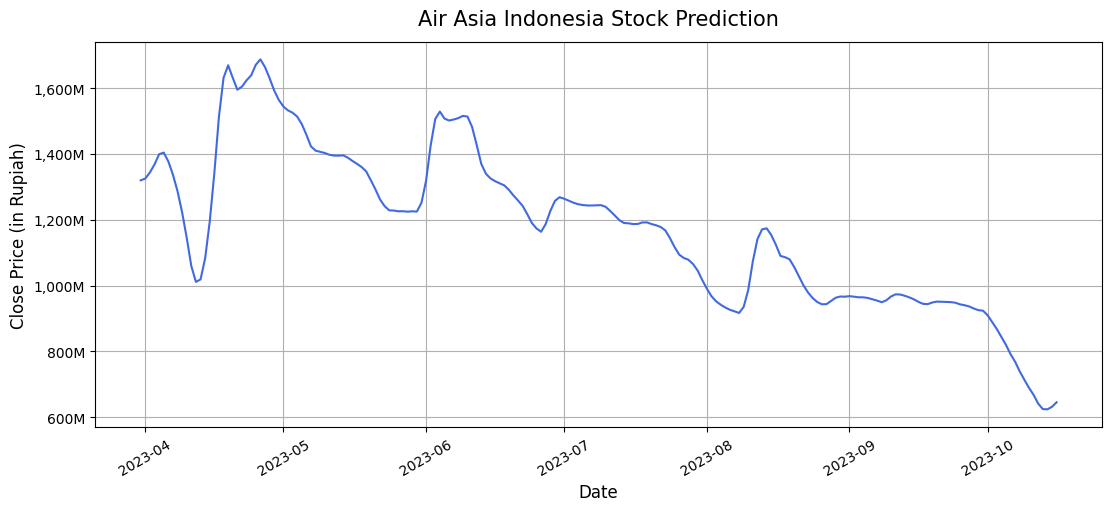

In [95]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaGrad

In [96]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_tanh_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 16s 378ms/step - loss: 0.0153 - val_loss: 0.0021
Epoch 2/10
24/24 [==============================] - 9s 378ms/step - loss: 0.0110 - val_loss: 0.0012
Epoch 3/10
24/24 [==============================] - 9s 369ms/step - loss: 0.0102 - val_loss: 0.0010
Epoch 4/10
24/24 [==============================] - 9s 380ms/step - loss: 0.0103 - val_loss: 0.0010
Epoch 5/10
24/24 [==============================] - 10s 405ms/step - loss: 0.0100 - val_loss: 0.0010
Epoch 6/10
24/24 [==============================] - 9s 377ms/step - loss: 0.0097 - val_loss: 0.0010
Epoch 7/10
24/24 [==============================] - 10s 398ms/step - loss: 0.0099 - val_loss: 0.0010
Epoch 8/10
24/24 [==============================] - 9s 373ms/step - loss: 0.0097 - val_loss: 0.0010
Epoch 9/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0095 - val_loss: 0.0010
Epoch 10/10
24/24 [==============================] - 9s 375ms/step - loss: 0.0093 - val_loss: 0.0

In [97]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 43ms/step
Mean Absolute Error (MAE): 0.0417103
Mean Absolute Percentage Error (MAPE): 0.25092
Root Mean Squared Error (RMSE): 0.07339
Mean Squared Error (MSE): 0.0053865
R-Squared (R2): 0.086675
T-Statistic 0.6853
P-Value 7.968051510551454e-21
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 44ms/step


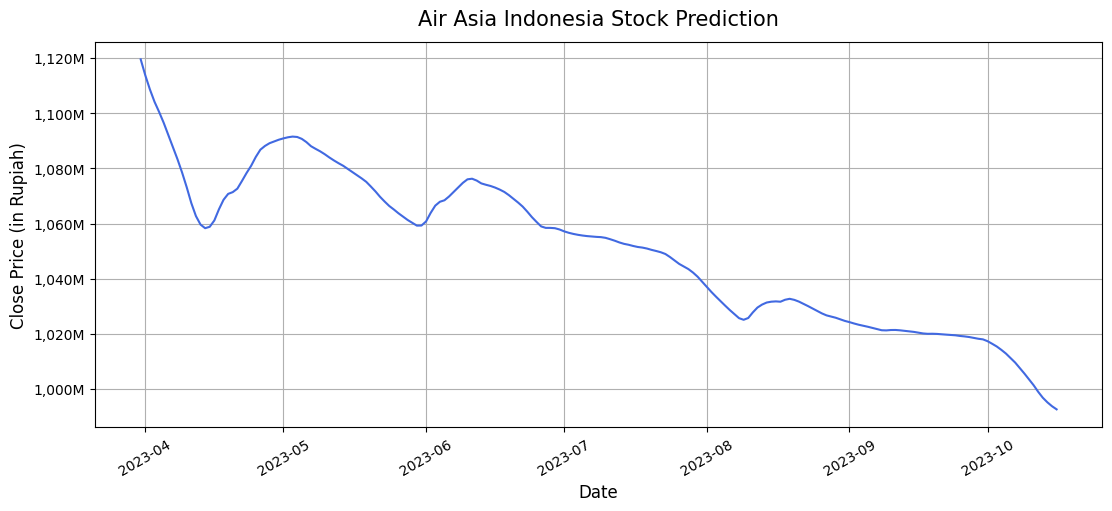

In [98]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Nadam

In [99]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_tanh_nadam.h5')

Epoch 1/10
24/24 [==============================] - 21s 439ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 2/10
24/24 [==============================] - 9s 366ms/step - loss: 0.0018 - val_loss: 8.6275e-04
Epoch 3/10
24/24 [==============================] - 9s 395ms/step - loss: 0.0014 - val_loss: 5.7124e-04
Epoch 4/10
24/24 [==============================] - 9s 383ms/step - loss: 0.0011 - val_loss: 4.8991e-04
Epoch 5/10
24/24 [==============================] - 9s 376ms/step - loss: 0.0011 - val_loss: 4.7741e-04
Epoch 6/10
24/24 [==============================] - 9s 374ms/step - loss: 0.0010 - val_loss: 4.0085e-04
Epoch 7/10
24/24 [==============================] - 9s 379ms/step - loss: 9.6123e-04 - val_loss: 3.9409e-04
Epoch 8/10
24/24 [==============================] - 9s 380ms/step - loss: 9.0780e-04 - val_loss: 3.5281e-04
Epoch 9/10
24/24 [==============================] - 9s 362ms/step - loss: 8.9976e-04 - val_loss: 2.9937e-04
Epoch 10/10
24/24 [==============================] - 9s

In [100]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 41ms/step
Mean Absolute Error (MAE): 0.0087454
Mean Absolute Percentage Error (MAPE): 0.05915
Root Mean Squared Error (RMSE): 0.01439
Mean Squared Error (MSE): 0.000207
R-Squared (R2): 0.964903
T-Statistic 0.7082
P-Value 4.073201156746485e-20
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 41ms/step


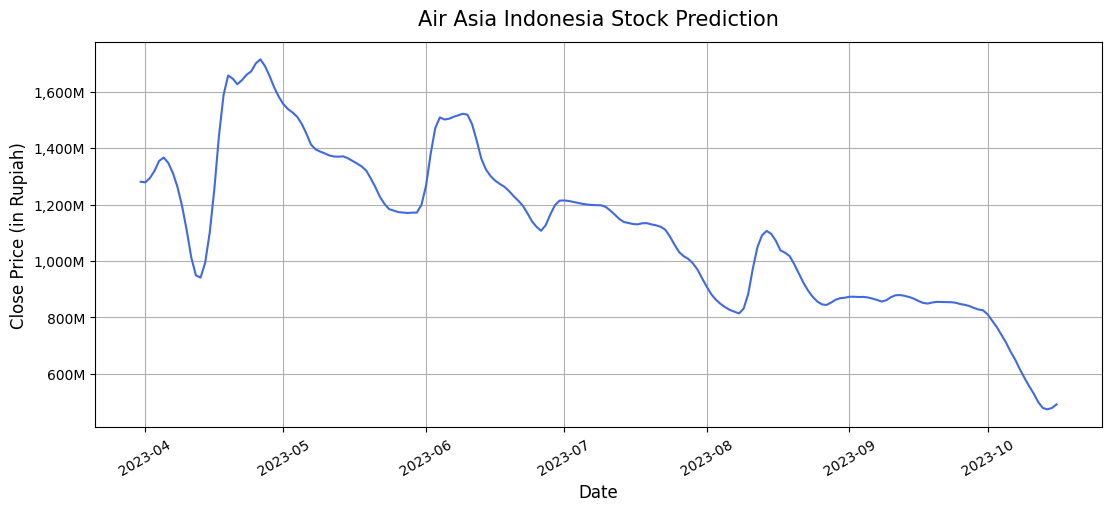

In [101]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - RMSProp

In [102]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_tanh_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 18s 428ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 2/10
24/24 [==============================] - 9s 368ms/step - loss: 0.0024 - val_loss: 7.4597e-04
Epoch 3/10
24/24 [==============================] - 9s 381ms/step - loss: 0.0022 - val_loss: 7.2037e-04
Epoch 4/10
24/24 [==============================] - 10s 404ms/step - loss: 0.0018 - val_loss: 8.2061e-04
Epoch 5/10
24/24 [==============================] - 9s 378ms/step - loss: 0.0016 - val_loss: 7.6350e-04
Epoch 6/10
24/24 [==============================] - 9s 382ms/step - loss: 0.0016 - val_loss: 5.3836e-04
Epoch 7/10
24/24 [==============================] - 9s 380ms/step - loss: 0.0015 - val_loss: 5.7178e-04
Epoch 8/10
24/24 [==============================] - 9s 369ms/step - loss: 0.0014 - val_loss: 7.3839e-04
Epoch 9/10
24/24 [==============================] - 9s 374ms/step - loss: 0.0015 - val_loss: 5.0253e-04
Epoch 10/10
24/24 [==============================] - 9s 390ms/step

In [103]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 48ms/step
Mean Absolute Error (MAE): 0.0169176
Mean Absolute Percentage Error (MAPE): 0.13412
Root Mean Squared Error (RMSE): 0.0208
Mean Squared Error (MSE): 0.0004328
R-Squared (R2): 0.926617
T-Statistic 0.6767
P-Value 4.414134632202726e-21
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 45ms/step


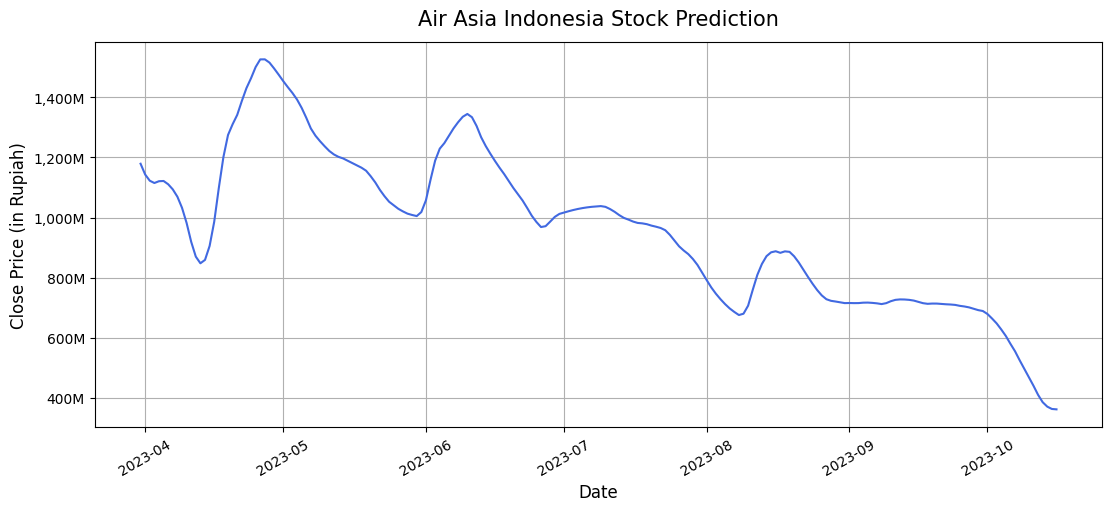

In [104]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaDelta

In [105]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_tanh_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 19s 417ms/step - loss: 0.0202 - val_loss: 0.0100
Epoch 2/10
24/24 [==============================] - 8s 326ms/step - loss: 0.0202 - val_loss: 0.0097
Epoch 3/10
24/24 [==============================] - 8s 342ms/step - loss: 0.0195 - val_loss: 0.0095
Epoch 4/10
24/24 [==============================] - 8s 345ms/step - loss: 0.0193 - val_loss: 0.0092
Epoch 5/10
24/24 [==============================] - 8s 354ms/step - loss: 0.0189 - val_loss: 0.0089
Epoch 6/10
24/24 [==============================] - 10s 403ms/step - loss: 0.0184 - val_loss: 0.0087
Epoch 7/10
24/24 [==============================] - 9s 376ms/step - loss: 0.0182 - val_loss: 0.0084
Epoch 8/10
24/24 [==============================] - 8s 343ms/step - loss: 0.0178 - val_loss: 0.0081
Epoch 9/10
24/24 [==============================] - 8s 346ms/step - loss: 0.0175 - val_loss: 0.0079
Epoch 10/10
24/24 [==============================] - 8s 353ms/step - loss: 0.0177 - val_loss: 0.00

In [106]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 2s 47ms/step
Mean Absolute Error (MAE): 0.1161715
Mean Absolute Percentage Error (MAPE): 0.82643
Root Mean Squared Error (RMSE): 0.13614
Mean Squared Error (MSE): 0.018535
R-Squared (R2): -2.142783
T-Statistic 0.6768
P-Value 4.456038115694499e-21
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 44ms/step


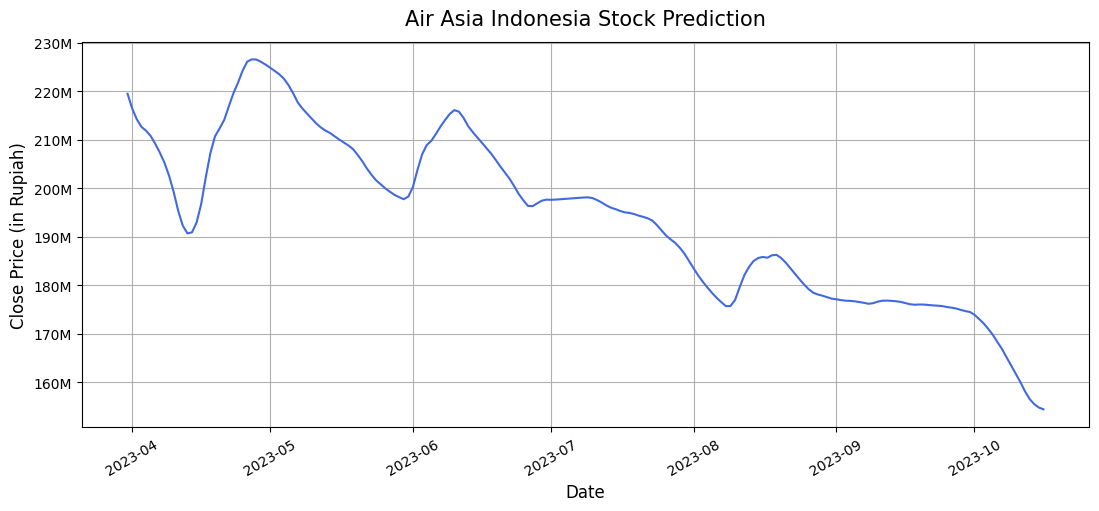

In [107]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - SGD

In [108]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_tanh_sgd.h5')

Epoch 1/10
24/24 [==============================] - 19s 455ms/step - loss: 0.0126 - val_loss: 0.0010
Epoch 2/10
24/24 [==============================] - 9s 369ms/step - loss: 0.0103 - val_loss: 0.0010
Epoch 3/10
24/24 [==============================] - 9s 396ms/step - loss: 0.0101 - val_loss: 0.0011
Epoch 4/10
24/24 [==============================] - 9s 389ms/step - loss: 0.0098 - val_loss: 0.0010
Epoch 5/10
24/24 [==============================] - 9s 393ms/step - loss: 0.0094 - val_loss: 0.0010
Epoch 6/10
24/24 [==============================] - 9s 370ms/step - loss: 0.0091 - val_loss: 0.0010
Epoch 7/10
24/24 [==============================] - 8s 353ms/step - loss: 0.0090 - val_loss: 0.0011
Epoch 8/10
24/24 [==============================] - 9s 367ms/step - loss: 0.0089 - val_loss: 0.0010
Epoch 9/10
24/24 [==============================] - 9s 370ms/step - loss: 0.0086 - val_loss: 0.0010
Epoch 10/10
24/24 [==============================] - 10s 399ms/step - loss: 0.0083 - val_loss: 0.00

In [109]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 4s 59ms/step
Mean Absolute Error (MAE): 0.0378999
Mean Absolute Percentage Error (MAPE): 0.23371
Root Mean Squared Error (RMSE): 0.06634
Mean Squared Error (MSE): 0.0044012
R-Squared (R2): 0.25373
T-Statistic 0.6662
P-Value 2.1927699758115883e-21
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 58ms/step


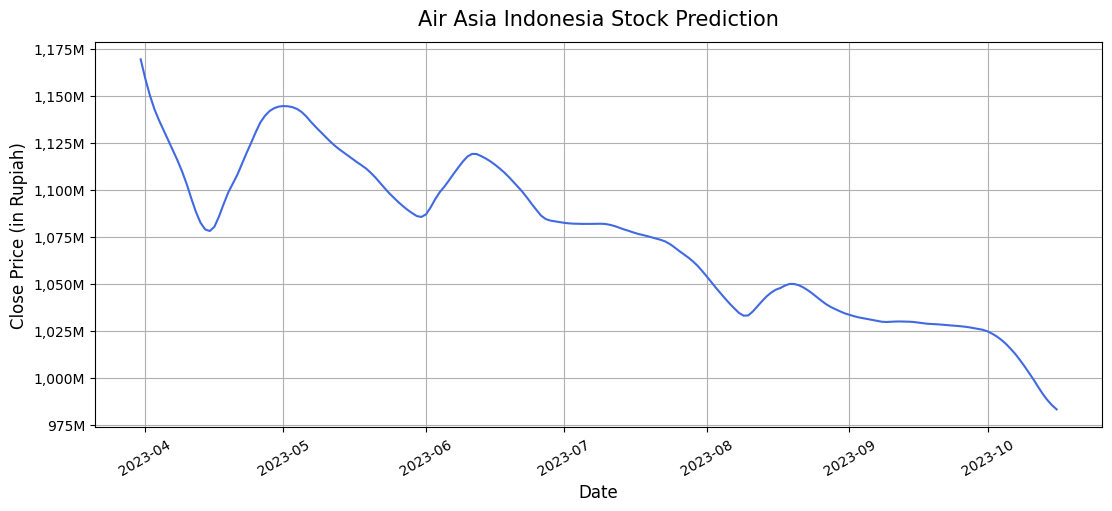

In [110]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaMax

In [111]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/cmpp_tanh_adamax.h5')

Epoch 1/10
24/24 [==============================] - 18s 394ms/step - loss: 0.0057 - val_loss: 8.4665e-04
Epoch 2/10
24/24 [==============================] - 8s 316ms/step - loss: 0.0024 - val_loss: 9.4181e-04
Epoch 3/10
24/24 [==============================] - 8s 318ms/step - loss: 0.0020 - val_loss: 7.6966e-04
Epoch 4/10
24/24 [==============================] - 8s 329ms/step - loss: 0.0019 - val_loss: 7.2973e-04
Epoch 5/10
24/24 [==============================] - 8s 337ms/step - loss: 0.0016 - val_loss: 7.5250e-04
Epoch 6/10
24/24 [==============================] - 9s 366ms/step - loss: 0.0017 - val_loss: 7.1076e-04
Epoch 7/10
24/24 [==============================] - 9s 384ms/step - loss: 0.0016 - val_loss: 6.4702e-04
Epoch 8/10
24/24 [==============================] - 9s 356ms/step - loss: 0.0013 - val_loss: 6.5910e-04
Epoch 9/10
24/24 [==============================] - 8s 345ms/step - loss: 0.0015 - val_loss: 6.1918e-04
Epoch 10/10
24/24 [==============================] - 8s 341ms/s

In [112]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)
if p > 0.05:
    print('Normal distribution')
else:
    print('Skew distribution')

8/8 [==============================] - 3s 45ms/step
Mean Absolute Error (MAE): 0.0163387
Mean Absolute Percentage Error (MAPE): 0.12507
Root Mean Squared Error (RMSE): 0.02225
Mean Squared Error (MSE): 0.000495
R-Squared (R2): 0.916072
T-Statistic 0.6724
P-Value 3.3174225888765143e-21
Elapsed Time (min): 12.13
Skew distribution


7/7 [==============================] - 0s 49ms/step


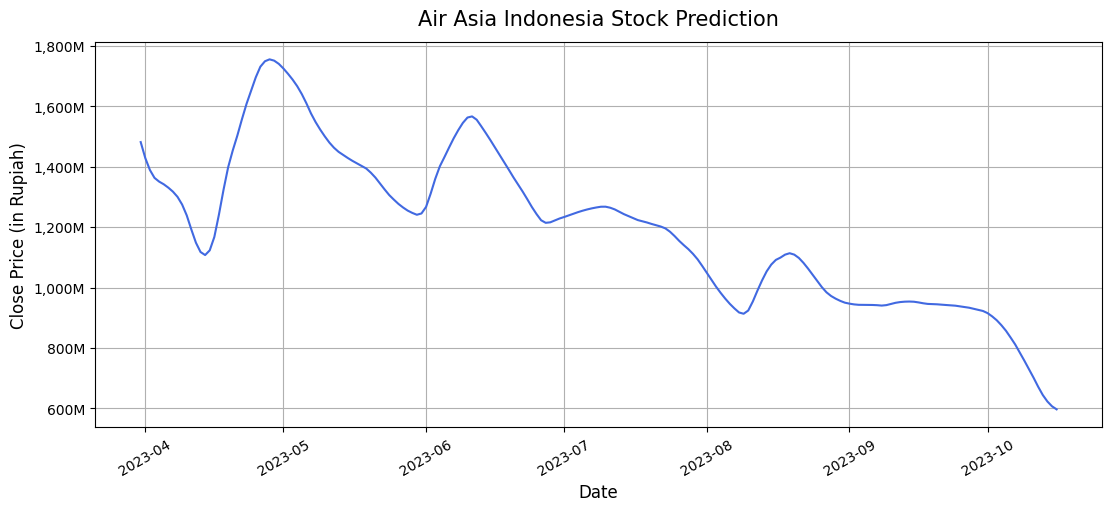

In [113]:
#prediction of linear regression for forecast 7 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_cmpp.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='royalblue')
plt.title('Air Asia Indonesia Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Comparison LSTM Model based on Activation and Optimizer Parameter

In [116]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    stat, p = stats.shapiro(preds)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time, stat, p])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 52ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 43ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 42ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 51ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 2s 55ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 59ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 53ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 53ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 58ms/step
Training

In [117]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta               112.35  0.13820   0.98804  0.02598   
           adagrad                111.17  0.04380   0.26324  0.00602   
           adam                    79.79  0.00842   0.05605  0.00021   
           adamax                 116.92  0.01033   0.07451  0.00024   
           nadam                  106.77  0.00789   0.05475  0.00017   
           rmsprop                111.23  0.00986   0.06946  0.00023   
           sgd                    118.42  0.03521   0.21385  0.00378   
relu       adadelta               120.13  0.11990   0.86008  0.01939   
           adagrad                123.00  0.03584   0.21659  0.00390   
           adam                   112.95  0.01018   0.07765  0.00021   
           adamax                 126.24  0.01119   0.08008  0.00027   
           nadam                  123.36  0.00882   0.06150  0.00020   
           rmsprop                120.88  0.04406   0.36386  0.00228   
           sgd                    130.95  0.04213   0.24990  0.00538   
sigmoid    adadelta               124.02  0.08972   0.83584  0.00963   
           adagrad                128.87  0.07471   0.45957  0.01112   
           adam                   116.77  0.03669   0.26910  0.00383   
           adamax                 102.38  0.01828   0.11797  0.00081   
           nadam                  116.73  0.02204   0.18939  0.00076   
           rmsprop                112.15  0.02737   0.22067  0.00096   
           sgd                    113.78  0.04683   0.27784  0.00677   
tanh       adadelta               133.84  0.13002   0.92659  0.02316   
           adagrad                129.71  0.04153   0.25134  0.00537   
           adam                   119.04  0.01061   0.07838  0.00022   
           adamax                 121.85  0.01083   0.07476  0.00030   
           nadam                  130.31  0.01304   0.09886  0.00029   
           rmsprop                128.53  0.02884   0.23299  0.00110   
           sgd                    118.27  0.03466   0.23012  0.00382   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     adadelta   2.597274e-21          -3.41   0.16118     0.668792  
           adagrad    5.680707e-21          -0.02   0.07759     0.680380  
           adam       4.335641e-20           0.96   0.01449     0.709043  
           adamax     4.687507e-21           0.96   0.01549     0.677563  
           nadam      4.000301e-20           0.97   0.01304     0.707946  
           rmsprop    5.224882e-21           0.96   0.01517     0.679156  
           sgd        5.199178e-21           0.36   0.06148     0.679084  
relu       adadelta   9.200844e-21          -2.29   0.13925     0.687365  
           adagrad    4.172280e-21           0.34   0.06245     0.675847  
           adam       4.989003e-20           0.96   0.01449     0.710949  
           adamax     7.923428e-21           0.95   0.01643     0.685212  
           nadam      5.978118e-20           0.97   0.01414     0.713390  
           rmsprop    3.557155e-20           0.61   0.04775     0.706340  
           sgd        1.901719e-21           0.09   0.07335     0.664089  
sigmoid    adadelta   3.221342e-21          -0.63   0.09813     0.672011  
           adagrad    1.768857e-21          -0.89   0.10545     0.662989  
           adam       2.856572e-12           0.35   0.06189     0.888099  
           adamax     5.292750e-22           0.86   0.02846     0.644259  
           nadam      4.669301e-20           0.87   0.02757     0.710051  
           rmsprop    3.395365e-21           0.84   0.03098     0.672795  
           sgd        7.825409e-22          -0.15   0.08228     0.650414  
tanh       adadelta   2.346188e-22          -2.93   0.15218     0.631189  
           adagrad    7.367104e-21           0.09   0.07328  

In [118]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get best of LSTM model evaluation 
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     nadam                  106.77  0.00789   0.05475  0.00017   
           adam                    79.79  0.00842   0.05605  0.00021   
relu       nadam                  123.36  0.00882   0.06150  0.00020   
linear     rmsprop                111.23  0.00986   0.06946  0.00023   
           adamax                 116.92  0.01033   0.07451  0.00024   
tanh       adamax                 121.85  0.01083   0.07476  0.00030   
relu       adam                   112.95  0.01018   0.07765  0.00021   
tanh       adam                   119.04  0.01061   0.07838  0.00022   
relu       adamax                 126.24  0.01119   0.08008  0.00027   
tanh       nadam                  130.31  0.01304   0.09886  0.00029   
sigmoid    adamax                 102.38  0.01828   0.11797  0.00081   
           nadam                  116.73  0.02204   0.18939  0.00076   
linear     sgd                    118.42  0.03521   0.21385  0.00378   
relu       adagrad                123.00  0.03584   0.21659  0.00390   
sigmoid    rmsprop                112.15  0.02737   0.22067  0.00096   
tanh       sgd                    118.27  0.03466   0.23012  0.00382   
           rmsprop                128.53  0.02884   0.23299  0.00110   
relu       sgd                    130.95  0.04213   0.24990  0.00538   
tanh       adagrad                129.71  0.04153   0.25134  0.00537   
linear     adagrad                111.17  0.04380   0.26324  0.00602   
sigmoid    adam                   116.77  0.03669   0.26910  0.00383   
           sgd                    113.78  0.04683   0.27784  0.00677   
relu       rmsprop                120.88  0.04406   0.36386  0.00228   
sigmoid    adagrad                128.87  0.07471   0.45957  0.01112   
           adadelta               124.02  0.08972   0.83584  0.00963   
relu       adadelta               120.13  0.11990   0.86008  0.01939   
tanh       adadelta               133.84  0.13002   0.92659  0.02316   
linear     adadelta               112.35  0.13820   0.98804  0.02598   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     nadam      4.000301e-20           0.97   0.01304     0.707946  
           adam       4.335641e-20           0.96   0.01449     0.709043  
relu       nadam      5.978118e-20           0.97   0.01414     0.713390  
linear     rmsprop    5.224882e-21           0.96   0.01517     0.679156  
           adamax     4.687507e-21           0.96   0.01549     0.677563  
tanh       adamax     6.892276e-21           0.95   0.01732     0.683194  
relu       adam       4.989003e-20           0.96   0.01449     0.710949  
tanh       adam       2.889090e-20           0.96   0.01483     0.703479  
relu       adamax     7.923428e-21           0.95   0.01643     0.685212  
tanh       nadam      4.977158e-20           0.95   0.01703     0.710916  
sigmoid    adamax     5.292750e-22           0.86   0.02846     0.644259  
           nadam      4.669301e-20           0.87   0.02757     0.710051  
linear     sgd        5.199178e-21           0.36   0.06148     0.679084  
relu       adagrad    4.172280e-21           0.34   0.06245     0.675847  
sigmoid    rmsprop    3.395365e-21           0.84   0.03098     0.672795  
tanh       sgd        7.849463e-21           0.35   0.06181     0.685077  
           rmsprop    5.375232e-21           0.81   0.03317     0.679571  
relu       sgd        1.901719e-21           0.09   0.07335     0.664089  
tanh       adagrad    7.367104e-21           0.09   0.07328     0.684160  
linear     adagrad    5.680707e-21          -0.02   0.07759     0.680380  
sigmoid    adam       2.856572e-12           0.35   0.06189     0.888099  
           sgd        7.825409e-22          -0.15   0.08228     0.650414  
relu       rmsprop    3.557155e-20           0.61   0.04775  

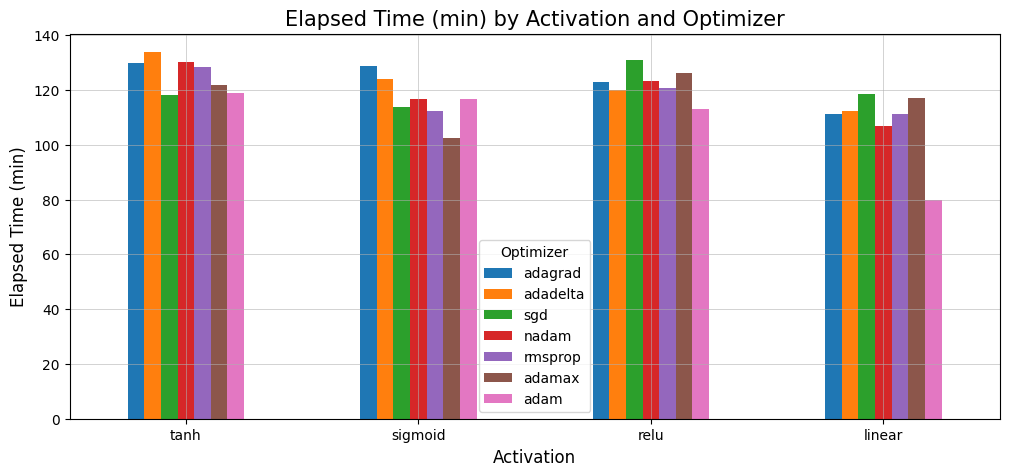

In [119]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

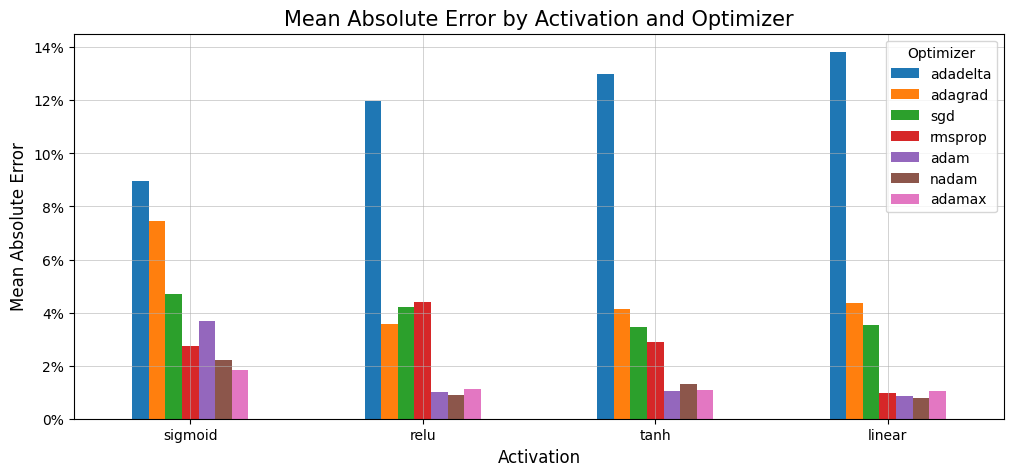

In [120]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

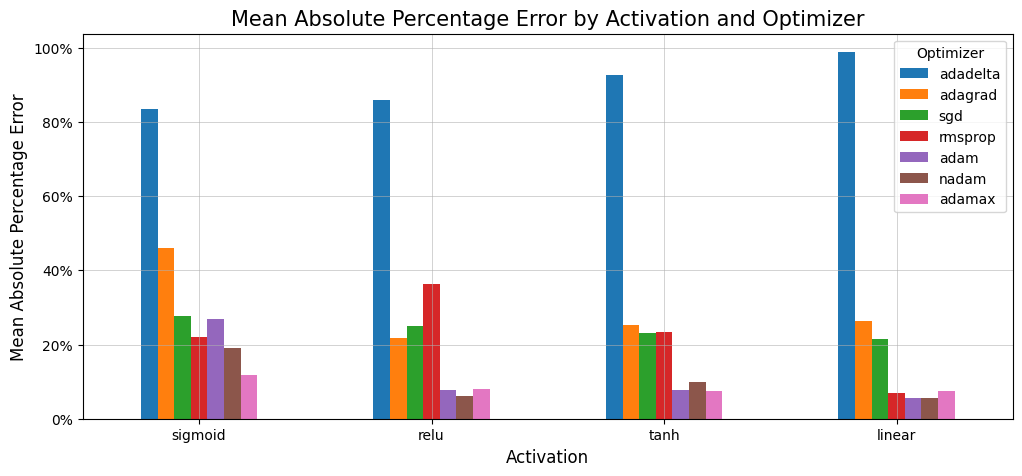

In [121]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

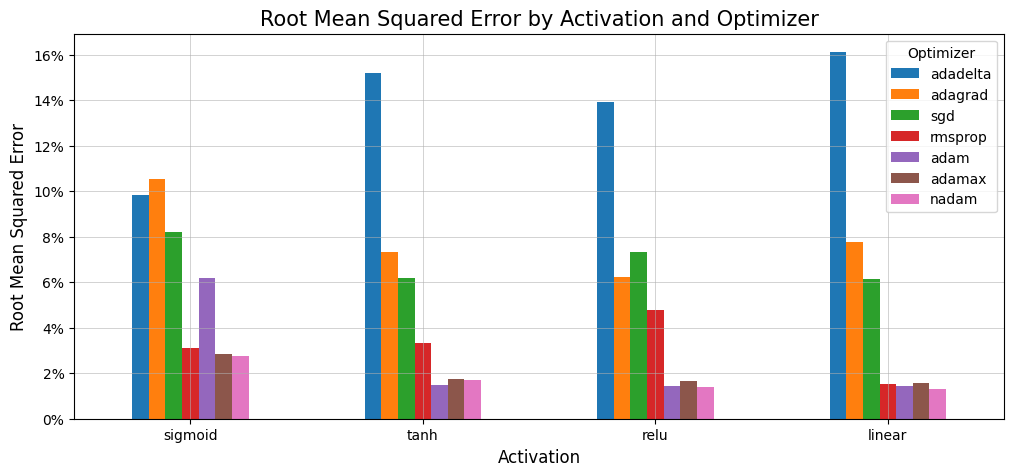

In [122]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

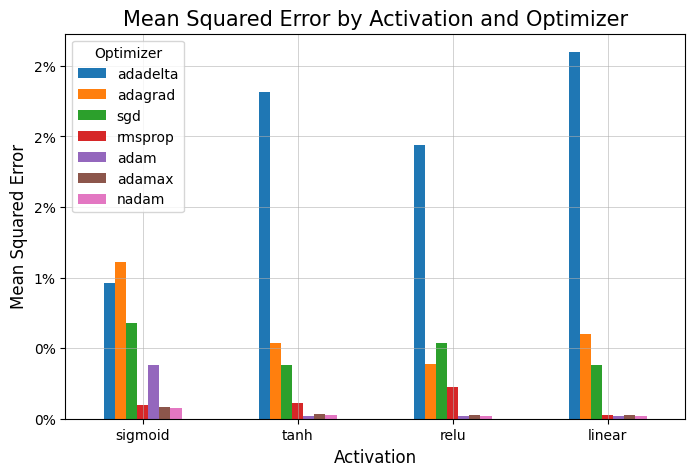

In [127]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean MSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=False)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_mse.plot(kind='bar', ax=ax) # modified line
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter) # modified line
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0) # modified line
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

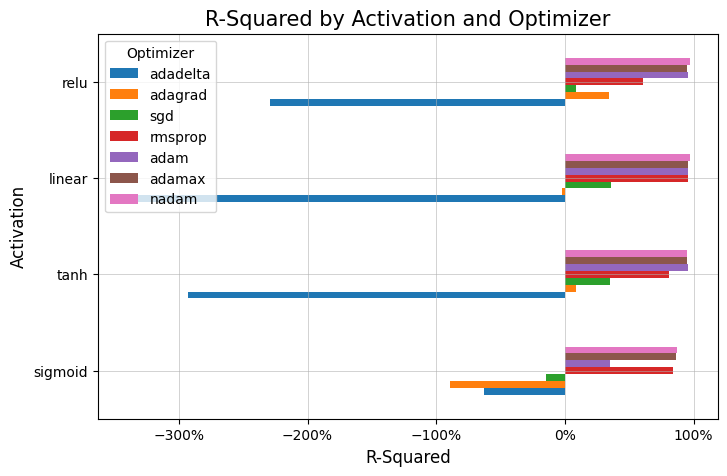

In [133]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean R2 value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=True).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean R2 value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=True)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()